In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [1]:
# Los datos se pueden descargar de: 
# https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset

data = pd.read_csv("data\ETH_1H.csv", 
                   parse_dates=["Date"],
                   index_col=["Date"])

NameError: name 'pd' is not defined

In [3]:
data = data.sort_index()

In [4]:
data = data.drop(columns=["Unix Timestamp", "Symbol"])

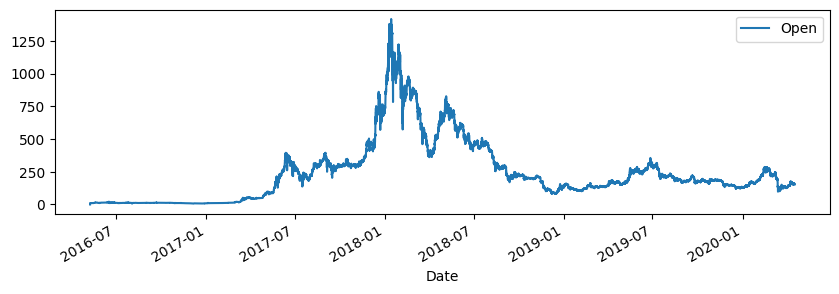

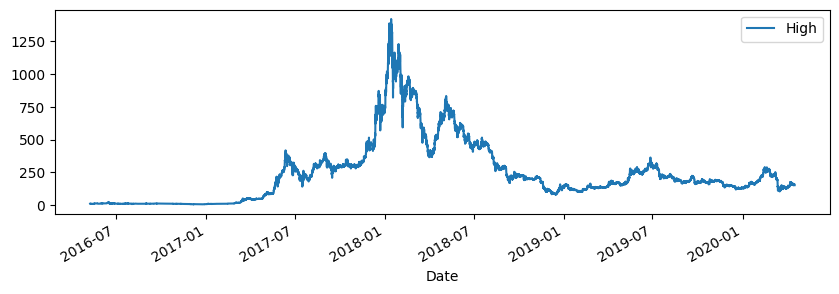

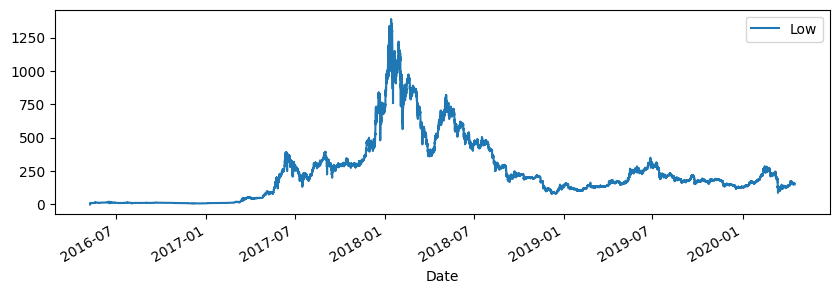

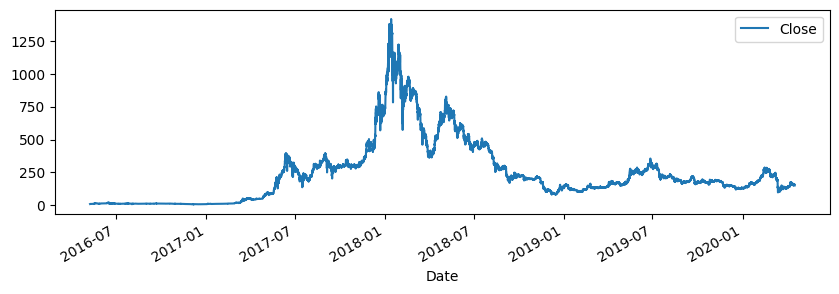

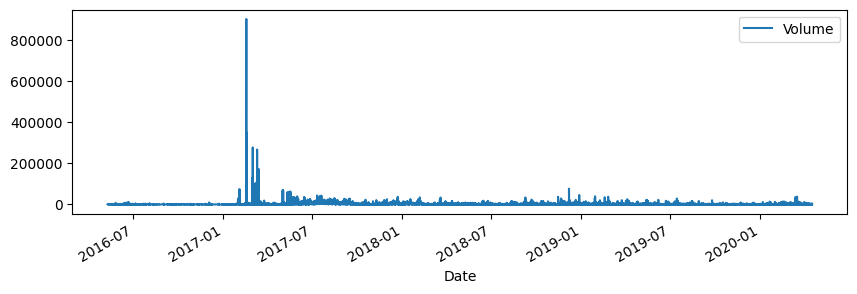

In [5]:
for i in data:
    plt.figure(figsize=(10, 3))
    data[i].plot(legend=i)
    plt.show()

In [6]:
def create_f(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofweek"] = df.index.dayofweek
    df["weekofyear"] = df.index.isocalendar().week

    return df

In [7]:
df = create_f(data)

In [8]:
df.head()

,Open,High,Low,Close,Volume,hour,day,month,year,dayofweek,weekofyear
Date,,,,,,,,,,,
2016-05-09 13:00:00,0.00,12.00,0.00,9.55,432.562115,13,9,5,2016,0,19
2016-05-09 14:00:00,9.55,10.00,9.55,10.00,235.774075,14,9,5,2016,0,19
2016-05-09 15:00:00,10.00,10.00,9.99,9.99,10.973567,15,9,5,2016,0,19
2016-05-09 16:00:00,9.99,9.99,9.79,9.83,62.379450,16,9,5,2016,0,19
2016-05-09 17:00:00,9.83,9.83,9.48,9.49,329.553213,17,9,5,2016,0,19


<Axes: >

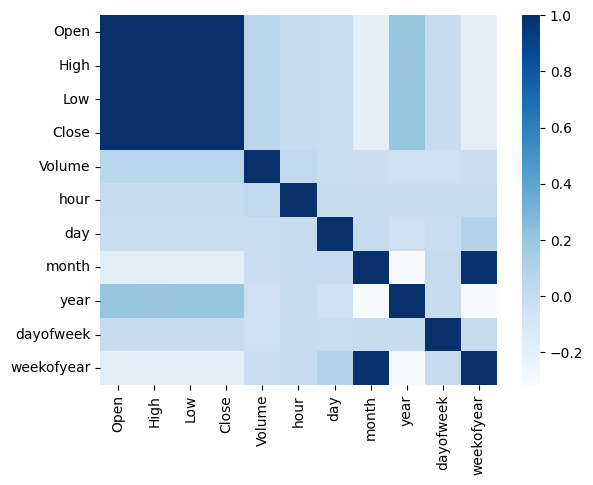

In [9]:
sns.heatmap(df.corr(), cmap="Blues")


In [10]:
close = df.iloc[:, 3]
windows = []
target = []
length = 240
for i in (range(len(close) - length)):
    x = close.iloc[i:i+length]
    y = close.iloc[i+length]
    windows.append(x)
    target.append(y)
windows = np.array(windows)
target = np.array(target).reshape(-1, 1)

In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
windows_sc = sc.fit_transform(windows)
target_sc = sc.fit_transform(target)

windows_sc = windows_sc.reshape((len(windows_sc), length, 1))

In [12]:
split = int(0.8 * len(windows_sc))
X_train = windows_sc[:split, :, :]
X_test = windows_sc[split:, :, :]
y_train = target_sc[:split, :]
y_test = target_sc[split:, :]

In [13]:
print(X_train.shape, y_train.shape)

(27405, 240, 1) (27405, 1)


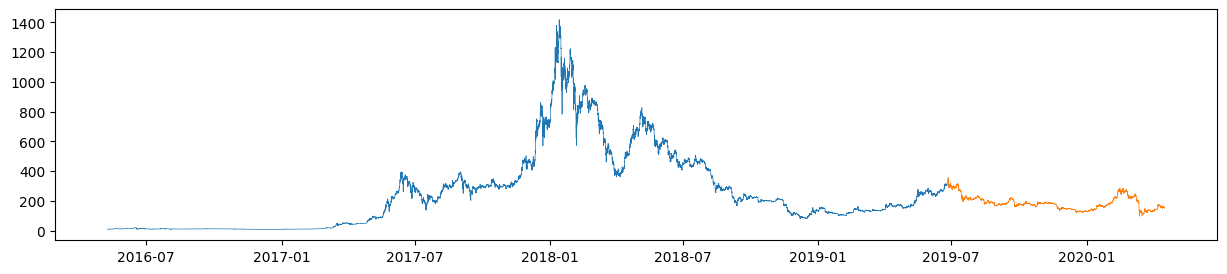

In [14]:
plt.figure(figsize=(15, 3))
plt.plot(df["Close"][:split], label="Train", linewidth=0.5)
plt.plot(df["Close"][split:], label="Test", linewidth=0.5)

In [15]:
# Model building and training

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import *

In [16]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam")

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#model.fit(X_train, y_train, epochs=5, batch_size=100, verbose=1)

In [20]:
# plt.plot(model.history.history["loss"])

In [21]:
# pred_sc = model.predict(X_test)
# pred = sc.inverse_transform(pred_sc)
# y_test_ic = sc.inverse_transform(y_test)

In [22]:
#  print("El coeciente de determinación es:{:.3f}".format(r2_score(pred, y_test_ic)))

In [23]:
# Nuevas predicciones
# Volvemos a entrenar, esta vez sobre todo el dataset

X = windows_sc
y = target_sc

model.fit(X, y, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
343/343 [==============================] - 138s 394ms/step - loss: 7.7001e-04
Epoch 2/5
343/343 [==============================] - 267s 778ms/step - loss: 2.0994e-04
Epoch 3/5
343/343 [==============================] - 248s 724ms/step - loss: 1.7805e-04
Epoch 4/5
343/343 [==============================] - 260s 758ms/step - loss: 1.6825e-04
Epoch 5/5
343/343 [==============================] - 249s 725ms/step - loss: 1.4757e-04


In [24]:
from datetime import datetime
from tqdm import tqdm

str_d1 = "2020-04-16"
str_d2 = "2020-05-30"

# Convertimos los strings en objetos de fecha
d1 = datetime.strptime(str_d1, "%Y-%m-%d")
d2 = datetime.strptime(str_d2, "%Y-%m-%d")

delta = d2 - d1
steps_in_future = delta.days * 24 # Diferencia de horas
print("Steps en el futuro: ", steps_in_future)

Steps en el futuro:  1056


In [25]:
# Predicción iterativa de cada step futuro
f_wind = windows_sc[-1]
f_tar = target_sc[-1]
new = []

for i in tqdm(range(steps_in_future)):
    curr = np.append(f_wind[1:], [f_tar]).reshape(-1,1)
    # print(curr,end="\n\n")
    next_pred = model.predict(curr.reshape(1, length, 1))
    pred_ic = sc.inverse_transform(next_pred)
    new.append(pred_ic[0][0])
    f_wind = curr
    f_tar = next_pred

  0%|          | 0/1056 [00:00<?, ?it/s]

1/1 [==============================] - 1s 708ms/step


  0%|          | 1/1056 [00:00<13:29,  1.30it/s]

1/1 [==============================] - 0s 129ms/step


  0%|          | 2/1056 [00:00<07:22,  2.38it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 4/1056 [00:01<03:43,  4.70it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 6/1056 [00:01<02:46,  6.32it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 7/1056 [00:01<02:31,  6.93it/s]

1/1 [==============================] - 0s 47ms/step


  1%|          | 9/1056 [00:01<02:10,  8.01it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 11/1056 [00:01<01:58,  8.78it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 13/1056 [00:01<01:51,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 14/1056 [00:02<01:51,  9.36it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 16/1056 [00:02<01:46,  9.80it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 18/1056 [00:02<01:46,  9.79it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 19/1056 [00:02<01:46,  9.75it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 21/1056 [00:02<01:44,  9.94it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 23/1056 [00:02<01:42, 10.12it/s]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 25/1056 [00:03<01:43,  9.96it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 27/1056 [00:03<01:40, 10.24it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 29/1056 [00:03<01:38, 10.48it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 31/1056 [00:03<01:36, 10.58it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 33/1056 [00:03<01:36, 10.56it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 35/1056 [00:04<01:35, 10.69it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 37/1056 [00:04<01:35, 10.66it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 39/1056 [00:04<01:34, 10.74it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 41/1056 [00:04<01:32, 10.94it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 43/1056 [00:04<01:31, 11.04it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 45/1056 [00:05<01:31, 11.10it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 47/1056 [00:05<01:32, 10.90it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▍         | 49/1056 [00:05<01:42,  9.80it/s]

1/1 [==============================] - 0s 72ms/step


  5%|▍         | 51/1056 [00:05<01:56,  8.66it/s]

1/1 [==============================] - 0s 77ms/step


  5%|▍         | 52/1056 [00:05<02:03,  8.12it/s]

1/1 [==============================] - 0s 73ms/step


  5%|▌         | 53/1056 [00:06<02:11,  7.63it/s]

1/1 [==============================] - 0s 80ms/step


  5%|▌         | 54/1056 [00:06<02:21,  7.08it/s]

1/1 [==============================] - 0s 78ms/step


  5%|▌         | 55/1056 [00:06<02:27,  6.78it/s]

1/1 [==============================] - 0s 91ms/step


  5%|▌         | 56/1056 [00:06<02:36,  6.39it/s]

1/1 [==============================] - 0s 118ms/step


  5%|▌         | 57/1056 [00:06<02:58,  5.58it/s]

1/1 [==============================] - 0s 107ms/step


  5%|▌         | 58/1056 [00:07<03:13,  5.15it/s]

1/1 [==============================] - 0s 84ms/step


  6%|▌         | 59/1056 [00:07<03:19,  4.99it/s]

1/1 [==============================] - 0s 81ms/step


  6%|▌         | 60/1056 [00:07<03:15,  5.09it/s]

1/1 [==============================] - 0s 82ms/step


  6%|▌         | 61/1056 [00:07<03:10,  5.23it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 62/1056 [00:07<03:14,  5.10it/s]

1/1 [==============================] - 0s 80ms/step


  6%|▌         | 63/1056 [00:08<03:16,  5.05it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 64/1056 [00:08<04:49,  3.43it/s]

1/1 [==============================] - 0s 79ms/step


  6%|▌         | 65/1056 [00:08<04:20,  3.81it/s]

1/1 [==============================] - 0s 83ms/step


  6%|▋         | 66/1056 [00:08<03:56,  4.19it/s]

1/1 [==============================] - 0s 87ms/step


  6%|▋         | 67/1056 [00:09<03:42,  4.44it/s]

1/1 [==============================] - 0s 83ms/step


  6%|▋         | 68/1056 [00:09<03:31,  4.66it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 69/1056 [00:09<03:28,  4.72it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 70/1056 [00:09<03:28,  4.74it/s]

1/1 [==============================] - 0s 87ms/step


  7%|▋         | 71/1056 [00:09<03:24,  4.83it/s]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 72/1056 [00:10<03:13,  5.08it/s]

1/1 [==============================] - 0s 74ms/step


  7%|▋         | 73/1056 [00:10<03:08,  5.22it/s]

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 74/1056 [00:10<03:01,  5.41it/s]

1/1 [==============================] - 0s 82ms/step


  7%|▋         | 75/1056 [00:10<02:58,  5.49it/s]

1/1 [==============================] - 0s 82ms/step


  7%|▋         | 76/1056 [00:10<02:56,  5.56it/s]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 77/1056 [00:10<02:52,  5.67it/s]

1/1 [==============================] - 0s 71ms/step


  7%|▋         | 78/1056 [00:11<02:47,  5.84it/s]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 79/1056 [00:11<02:48,  5.81it/s]

1/1 [==============================] - 0s 80ms/step


  8%|▊         | 80/1056 [00:11<02:50,  5.72it/s]

1/1 [==============================] - 0s 80ms/step


  8%|▊         | 81/1056 [00:11<02:49,  5.74it/s]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 82/1056 [00:11<02:51,  5.67it/s]

1/1 [==============================] - 0s 74ms/step


  8%|▊         | 83/1056 [00:12<02:47,  5.81it/s]

1/1 [==============================] - 0s 80ms/step


  8%|▊         | 84/1056 [00:12<02:48,  5.76it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 85/1056 [00:12<03:01,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


  8%|▊         | 86/1056 [00:12<02:59,  5.40it/s]

1/1 [==============================] - 0s 77ms/step


  8%|▊         | 87/1056 [00:12<02:53,  5.58it/s]

1/1 [==============================] - 0s 81ms/step


  8%|▊         | 88/1056 [00:12<02:55,  5.52it/s]

1/1 [==============================] - 0s 72ms/step


  8%|▊         | 89/1056 [00:13<02:51,  5.65it/s]

1/1 [==============================] - 0s 70ms/step


  9%|▊         | 90/1056 [00:13<02:45,  5.82it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▊         | 91/1056 [00:13<02:47,  5.76it/s]

1/1 [==============================] - 0s 84ms/step


  9%|▊         | 92/1056 [00:13<02:48,  5.72it/s]

1/1 [==============================] - 0s 79ms/step


  9%|▉         | 93/1056 [00:13<02:49,  5.69it/s]

1/1 [==============================] - 0s 81ms/step


  9%|▉         | 94/1056 [00:13<02:46,  5.76it/s]

1/1 [==============================] - 0s 82ms/step


  9%|▉         | 95/1056 [00:14<02:51,  5.59it/s]

1/1 [==============================] - 0s 83ms/step


  9%|▉         | 96/1056 [00:14<02:50,  5.64it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 97/1056 [00:14<02:49,  5.67it/s]

1/1 [==============================] - 0s 78ms/step


  9%|▉         | 98/1056 [00:14<02:47,  5.71it/s]

1/1 [==============================] - 0s 85ms/step


  9%|▉         | 99/1056 [00:14<02:49,  5.65it/s]

1/1 [==============================] - 0s 91ms/step


  9%|▉         | 100/1056 [00:15<02:53,  5.53it/s]

1/1 [==============================] - 0s 85ms/step


 10%|▉         | 101/1056 [00:15<02:52,  5.53it/s]

1/1 [==============================] - 0s 82ms/step


 10%|▉         | 102/1056 [00:15<02:49,  5.62it/s]

1/1 [==============================] - 0s 80ms/step


 10%|▉         | 103/1056 [00:15<02:49,  5.61it/s]

1/1 [==============================] - 0s 80ms/step


 10%|▉         | 104/1056 [00:15<02:48,  5.64it/s]

1/1 [==============================] - 0s 75ms/step


 10%|▉         | 105/1056 [00:15<02:43,  5.82it/s]

1/1 [==============================] - 0s 76ms/step


 10%|█         | 106/1056 [00:16<02:41,  5.90it/s]

1/1 [==============================] - 0s 79ms/step


 10%|█         | 107/1056 [00:16<02:40,  5.93it/s]

1/1 [==============================] - 0s 80ms/step


 10%|█         | 108/1056 [00:16<02:40,  5.92it/s]

1/1 [==============================] - 0s 80ms/step


 10%|█         | 109/1056 [00:16<02:45,  5.74it/s]

1/1 [==============================] - 0s 79ms/step


 10%|█         | 110/1056 [00:16<02:42,  5.83it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█         | 111/1056 [00:16<02:39,  5.94it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█         | 112/1056 [00:17<02:39,  5.93it/s]

1/1 [==============================] - 0s 75ms/step


 11%|█         | 113/1056 [00:17<02:37,  5.99it/s]

1/1 [==============================] - 0s 84ms/step


 11%|█         | 114/1056 [00:17<02:39,  5.92it/s]

1/1 [==============================] - 0s 87ms/step


 11%|█         | 115/1056 [00:17<02:43,  5.76it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 116/1056 [00:17<02:45,  5.68it/s]

1/1 [==============================] - 0s 75ms/step


 11%|█         | 117/1056 [00:17<02:45,  5.68it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 118/1056 [00:18<02:49,  5.53it/s]

1/1 [==============================] - 0s 92ms/step


 11%|█▏        | 119/1056 [00:18<03:03,  5.10it/s]

1/1 [==============================] - 0s 87ms/step


 11%|█▏        | 120/1056 [00:18<03:01,  5.15it/s]

1/1 [==============================] - 0s 85ms/step


 11%|█▏        | 121/1056 [00:18<02:58,  5.23it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 122/1056 [00:18<02:54,  5.34it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 123/1056 [00:19<02:48,  5.55it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 124/1056 [00:19<02:43,  5.69it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 125/1056 [00:19<02:40,  5.80it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 126/1056 [00:19<02:37,  5.92it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 127/1056 [00:19<02:35,  5.98it/s]

1/1 [==============================] - 0s 70ms/step


 12%|█▏        | 128/1056 [00:19<02:34,  6.03it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█▏        | 129/1056 [00:20<02:35,  5.96it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█▏        | 130/1056 [00:20<02:33,  6.04it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█▏        | 131/1056 [00:20<02:33,  6.02it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█▎        | 132/1056 [00:20<02:30,  6.13it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 133/1056 [00:20<02:28,  6.23it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 134/1056 [00:20<02:25,  6.33it/s]

1/1 [==============================] - 0s 74ms/step


 13%|█▎        | 135/1056 [00:21<02:26,  6.30it/s]

1/1 [==============================] - 0s 75ms/step


 13%|█▎        | 136/1056 [00:21<02:26,  6.29it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 137/1056 [00:21<02:32,  6.04it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 138/1056 [00:21<02:32,  6.03it/s]

1/1 [==============================] - 0s 79ms/step


 13%|█▎        | 139/1056 [00:21<02:33,  5.99it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 140/1056 [00:21<02:34,  5.92it/s]

1/1 [==============================] - 0s 78ms/step


 13%|█▎        | 141/1056 [00:22<02:36,  5.86it/s]

1/1 [==============================] - 0s 78ms/step


 13%|█▎        | 142/1056 [00:22<02:35,  5.89it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▎        | 143/1056 [00:22<02:35,  5.86it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▎        | 144/1056 [00:22<02:34,  5.92it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█▎        | 145/1056 [00:22<02:36,  5.83it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 146/1056 [00:22<02:37,  5.79it/s]

1/1 [==============================] - 0s 77ms/step


 14%|█▍        | 147/1056 [00:23<02:34,  5.89it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▍        | 148/1056 [00:23<02:33,  5.91it/s]

1/1 [==============================] - 0s 76ms/step


 14%|█▍        | 149/1056 [00:23<02:34,  5.89it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█▍        | 150/1056 [00:23<02:45,  5.46it/s]

1/1 [==============================] - 0s 92ms/step


 14%|█▍        | 151/1056 [00:23<02:48,  5.37it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▍        | 152/1056 [00:24<02:47,  5.41it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 153/1056 [00:24<02:42,  5.56it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▍        | 154/1056 [00:24<02:38,  5.68it/s]

1/1 [==============================] - 0s 76ms/step


 15%|█▍        | 155/1056 [00:24<02:36,  5.76it/s]

1/1 [==============================] - 0s 74ms/step


 15%|█▍        | 156/1056 [00:24<02:34,  5.81it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█▍        | 157/1056 [00:24<02:34,  5.81it/s]

1/1 [==============================] - 0s 78ms/step


 15%|█▍        | 158/1056 [00:25<02:32,  5.90it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 159/1056 [00:25<02:30,  5.96it/s]

1/1 [==============================] - 0s 80ms/step


 15%|█▌        | 160/1056 [00:25<02:30,  5.97it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▌        | 161/1056 [00:25<02:31,  5.92it/s]

1/1 [==============================] - 0s 76ms/step


 15%|█▌        | 162/1056 [00:25<02:30,  5.94it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█▌        | 163/1056 [00:25<02:30,  5.92it/s]

1/1 [==============================] - 0s 87ms/step


 16%|█▌        | 164/1056 [00:26<02:37,  5.65it/s]

1/1 [==============================] - 0s 87ms/step


 16%|█▌        | 165/1056 [00:26<02:43,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


 16%|█▌        | 166/1056 [00:26<02:42,  5.49it/s]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 167/1056 [00:26<02:37,  5.65it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 168/1056 [00:26<02:34,  5.76it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▌        | 169/1056 [00:26<02:30,  5.90it/s]

1/1 [==============================] - 0s 77ms/step


 16%|█▌        | 170/1056 [00:27<02:30,  5.90it/s]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 171/1056 [00:27<02:28,  5.95it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▋        | 172/1056 [00:27<02:29,  5.92it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▋        | 173/1056 [00:27<02:29,  5.92it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▋        | 174/1056 [00:27<02:29,  5.90it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 175/1056 [00:27<02:24,  6.09it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 176/1056 [00:28<02:21,  6.24it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█▋        | 177/1056 [00:28<02:33,  5.72it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 178/1056 [00:28<02:31,  5.81it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█▋        | 179/1056 [00:28<02:33,  5.73it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 180/1056 [00:28<02:28,  5.89it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 181/1056 [00:28<02:24,  6.04it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 182/1056 [00:29<02:23,  6.11it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 183/1056 [00:29<02:22,  6.13it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█▋        | 184/1056 [00:29<02:22,  6.13it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 185/1056 [00:29<02:23,  6.05it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 186/1056 [00:29<02:24,  6.02it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 187/1056 [00:29<02:24,  6.01it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 188/1056 [00:30<02:23,  6.04it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█▊        | 189/1056 [00:30<02:24,  6.00it/s]

1/1 [==============================] - 0s 81ms/step


 18%|█▊        | 190/1056 [00:30<02:24,  6.00it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 191/1056 [00:30<02:22,  6.08it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 192/1056 [00:30<02:22,  6.06it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█▊        | 193/1056 [00:30<02:23,  6.00it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 194/1056 [00:31<02:22,  6.06it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 195/1056 [00:31<02:21,  6.07it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▊        | 196/1056 [00:31<02:19,  6.15it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▊        | 197/1056 [00:31<02:16,  6.28it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 198/1056 [00:31<02:17,  6.26it/s]

1/1 [==============================] - 0s 73ms/step


 19%|█▉        | 199/1056 [00:31<02:15,  6.30it/s]

1/1 [==============================] - 0s 87ms/step


 19%|█▉        | 200/1056 [00:32<02:29,  5.71it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 201/1056 [00:32<02:28,  5.76it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 202/1056 [00:32<02:27,  5.77it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 203/1056 [00:32<02:26,  5.83it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 204/1056 [00:32<02:22,  5.97it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 205/1056 [00:32<02:20,  6.05it/s]

1/1 [==============================] - 0s 75ms/step


 20%|█▉        | 206/1056 [00:33<02:19,  6.10it/s]

1/1 [==============================] - 0s 70ms/step


 20%|█▉        | 207/1056 [00:33<02:18,  6.14it/s]

1/1 [==============================] - 0s 89ms/step


 20%|█▉        | 208/1056 [00:33<02:23,  5.91it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 209/1056 [00:33<02:25,  5.84it/s]

1/1 [==============================] - 0s 80ms/step


 20%|█▉        | 210/1056 [00:33<02:26,  5.79it/s]

1/1 [==============================] - 0s 84ms/step


 20%|█▉        | 211/1056 [00:33<02:30,  5.63it/s]

1/1 [==============================] - 0s 71ms/step


 20%|██        | 212/1056 [00:34<02:27,  5.71it/s]

1/1 [==============================] - 0s 74ms/step


 20%|██        | 213/1056 [00:34<02:26,  5.76it/s]

1/1 [==============================] - 0s 78ms/step


 20%|██        | 214/1056 [00:34<02:22,  5.89it/s]

1/1 [==============================] - 0s 76ms/step


 20%|██        | 215/1056 [00:34<02:21,  5.96it/s]

1/1 [==============================] - 0s 65ms/step


 20%|██        | 216/1056 [00:34<02:16,  6.14it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██        | 217/1056 [00:34<02:15,  6.19it/s]

1/1 [==============================] - 0s 93ms/step


 21%|██        | 218/1056 [00:35<02:32,  5.51it/s]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 219/1056 [00:35<02:39,  5.25it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██        | 220/1056 [00:35<03:14,  4.30it/s]

1/1 [==============================] - 0s 87ms/step


 21%|██        | 221/1056 [00:35<03:06,  4.49it/s]

1/1 [==============================] - 0s 76ms/step


 21%|██        | 222/1056 [00:36<02:55,  4.75it/s]

1/1 [==============================] - 0s 70ms/step


 21%|██        | 223/1056 [00:36<02:44,  5.07it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 224/1056 [00:36<02:38,  5.26it/s]

1/1 [==============================] - 0s 85ms/step


 21%|██▏       | 225/1056 [00:36<02:35,  5.34it/s]

1/1 [==============================] - 0s 78ms/step


 21%|██▏       | 226/1056 [00:36<02:30,  5.51it/s]

1/1 [==============================] - 0s 75ms/step


 21%|██▏       | 227/1056 [00:36<02:25,  5.69it/s]

1/1 [==============================] - 0s 72ms/step


 22%|██▏       | 228/1056 [00:37<02:20,  5.91it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 229/1056 [00:37<02:17,  6.00it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 230/1056 [00:37<02:19,  5.94it/s]

1/1 [==============================] - 0s 80ms/step


 22%|██▏       | 231/1056 [00:37<02:20,  5.88it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 232/1056 [00:37<02:19,  5.91it/s]

1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 233/1056 [00:37<02:18,  5.95it/s]

1/1 [==============================] - 0s 76ms/step


 22%|██▏       | 234/1056 [00:38<02:17,  5.97it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 235/1056 [00:38<02:17,  5.95it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 236/1056 [00:38<02:17,  5.94it/s]

1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 237/1056 [00:38<02:20,  5.83it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██▎       | 238/1056 [00:38<02:36,  5.22it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██▎       | 239/1056 [00:39<02:35,  5.26it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 240/1056 [00:39<02:32,  5.35it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██▎       | 241/1056 [00:39<02:29,  5.44it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 242/1056 [00:39<02:27,  5.53it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 243/1056 [00:39<02:24,  5.61it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 244/1056 [00:39<02:21,  5.74it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 245/1056 [00:40<02:20,  5.79it/s]

1/1 [==============================] - 0s 73ms/step


 23%|██▎       | 246/1056 [00:40<02:16,  5.93it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 247/1056 [00:40<02:16,  5.93it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 248/1056 [00:40<02:17,  5.87it/s]

1/1 [==============================] - 0s 69ms/step


 24%|██▎       | 249/1056 [00:40<02:13,  6.06it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▎       | 250/1056 [00:40<02:10,  6.17it/s]

1/1 [==============================] - 0s 71ms/step


 24%|██▍       | 251/1056 [00:41<02:09,  6.19it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 252/1056 [00:41<02:12,  6.07it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▍       | 253/1056 [00:41<02:13,  6.01it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▍       | 254/1056 [00:41<02:15,  5.91it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 255/1056 [00:41<02:17,  5.82it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██▍       | 256/1056 [00:41<02:18,  5.79it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 257/1056 [00:42<02:18,  5.78it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██▍       | 258/1056 [00:42<02:30,  5.31it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▍       | 259/1056 [00:42<02:31,  5.28it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 260/1056 [00:42<02:27,  5.39it/s]

1/1 [==============================] - 0s 82ms/step


 25%|██▍       | 261/1056 [00:42<02:24,  5.49it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 262/1056 [00:43<02:24,  5.51it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▍       | 263/1056 [00:43<02:21,  5.62it/s]

1/1 [==============================] - 0s 74ms/step


 25%|██▌       | 264/1056 [00:43<02:17,  5.75it/s]

1/1 [==============================] - 0s 80ms/step


 25%|██▌       | 265/1056 [00:43<02:16,  5.80it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▌       | 266/1056 [00:43<02:19,  5.65it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 267/1056 [00:43<02:18,  5.68it/s]

1/1 [==============================] - 0s 82ms/step


 25%|██▌       | 268/1056 [00:44<02:19,  5.64it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▌       | 269/1056 [00:44<02:20,  5.62it/s]

1/1 [==============================] - 0s 84ms/step


 26%|██▌       | 270/1056 [00:44<02:18,  5.67it/s]

1/1 [==============================] - 0s 73ms/step


 26%|██▌       | 271/1056 [00:44<02:15,  5.79it/s]

1/1 [==============================] - 0s 69ms/step


 26%|██▌       | 272/1056 [00:44<02:11,  5.98it/s]

1/1 [==============================] - 0s 73ms/step


 26%|██▌       | 273/1056 [00:44<02:08,  6.08it/s]

1/1 [==============================] - 0s 75ms/step


 26%|██▌       | 274/1056 [00:45<02:07,  6.14it/s]

1/1 [==============================] - 0s 73ms/step


 26%|██▌       | 275/1056 [00:45<02:08,  6.09it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 276/1056 [00:45<02:24,  5.41it/s]

1/1 [==============================] - 0s 81ms/step


 26%|██▌       | 277/1056 [00:45<02:22,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▋       | 278/1056 [00:45<02:23,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


 26%|██▋       | 279/1056 [00:46<02:21,  5.50it/s]

1/1 [==============================] - 0s 82ms/step


 27%|██▋       | 280/1056 [00:46<02:21,  5.48it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 281/1056 [00:46<02:20,  5.53it/s]

1/1 [==============================] - 0s 81ms/step


 27%|██▋       | 282/1056 [00:46<02:18,  5.58it/s]

1/1 [==============================] - 0s 74ms/step


 27%|██▋       | 283/1056 [00:46<02:14,  5.73it/s]

1/1 [==============================] - 0s 74ms/step


 27%|██▋       | 284/1056 [00:46<02:14,  5.75it/s]

1/1 [==============================] - 0s 79ms/step


 27%|██▋       | 285/1056 [00:47<02:12,  5.82it/s]

1/1 [==============================] - 0s 82ms/step


 27%|██▋       | 286/1056 [00:47<02:13,  5.75it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██▋       | 287/1056 [00:47<02:21,  5.42it/s]

1/1 [==============================] - 0s 130ms/step


 27%|██▋       | 288/1056 [00:47<02:45,  4.64it/s]

1/1 [==============================] - 0s 128ms/step


 27%|██▋       | 289/1056 [00:48<02:58,  4.29it/s]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 290/1056 [00:48<03:00,  4.25it/s]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 291/1056 [00:48<02:55,  4.36it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██▊       | 292/1056 [00:48<02:45,  4.60it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██▊       | 293/1056 [00:48<02:40,  4.76it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 294/1056 [00:49<02:42,  4.70it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██▊       | 295/1056 [00:49<02:34,  4.93it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██▊       | 296/1056 [00:49<02:34,  4.93it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 297/1056 [00:49<02:54,  4.34it/s]

1/1 [==============================] - 0s 113ms/step


 28%|██▊       | 298/1056 [00:50<03:00,  4.19it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 299/1056 [00:50<02:52,  4.40it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██▊       | 300/1056 [00:50<02:42,  4.65it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██▊       | 301/1056 [00:50<02:32,  4.94it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▊       | 302/1056 [00:50<02:28,  5.09it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██▊       | 303/1056 [00:50<02:23,  5.26it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██▉       | 304/1056 [00:51<02:18,  5.43it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 305/1056 [00:51<02:15,  5.54it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██▉       | 306/1056 [00:51<02:15,  5.52it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 307/1056 [00:51<02:15,  5.55it/s]

1/1 [==============================] - 0s 77ms/step


 29%|██▉       | 308/1056 [00:51<02:12,  5.63it/s]

1/1 [==============================] - 0s 72ms/step


 29%|██▉       | 309/1056 [00:51<02:09,  5.75it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 310/1056 [00:52<02:08,  5.80it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██▉       | 311/1056 [00:52<02:20,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


 30%|██▉       | 312/1056 [00:52<02:18,  5.36it/s]

1/1 [==============================] - 0s 85ms/step


 30%|██▉       | 313/1056 [00:52<02:17,  5.40it/s]

1/1 [==============================] - 0s 80ms/step


 30%|██▉       | 314/1056 [00:52<02:14,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


 30%|██▉       | 315/1056 [00:53<02:08,  5.75it/s]

1/1 [==============================] - 0s 79ms/step


 30%|██▉       | 316/1056 [00:53<02:06,  5.84it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███       | 317/1056 [00:53<02:11,  5.63it/s]

1/1 [==============================] - 0s 126ms/step


 30%|███       | 318/1056 [00:53<02:34,  4.78it/s]

1/1 [==============================] - 0s 137ms/step


 30%|███       | 319/1056 [00:53<02:48,  4.37it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███       | 320/1056 [00:54<02:49,  4.33it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███       | 321/1056 [00:54<02:44,  4.46it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███       | 322/1056 [00:54<02:37,  4.67it/s]

1/1 [==============================] - 0s 82ms/step


 31%|███       | 323/1056 [00:54<02:31,  4.84it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███       | 324/1056 [00:54<02:26,  4.98it/s]

1/1 [==============================] - 0s 77ms/step


 31%|███       | 325/1056 [00:55<02:19,  5.23it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███       | 326/1056 [00:55<02:26,  5.00it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███       | 327/1056 [00:55<02:21,  5.14it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███       | 328/1056 [00:55<02:18,  5.26it/s]

1/1 [==============================] - 0s 82ms/step


 31%|███       | 329/1056 [00:55<02:16,  5.31it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███▏      | 330/1056 [00:56<02:12,  5.46it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███▏      | 331/1056 [00:56<02:08,  5.62it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███▏      | 332/1056 [00:56<02:07,  5.69it/s]

1/1 [==============================] - 0s 84ms/step


 32%|███▏      | 333/1056 [00:56<02:05,  5.75it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 334/1056 [00:56<02:07,  5.67it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 335/1056 [00:56<02:04,  5.80it/s]

1/1 [==============================] - 0s 72ms/step


 32%|███▏      | 336/1056 [00:57<02:01,  5.93it/s]

1/1 [==============================] - 0s 88ms/step


 32%|███▏      | 337/1056 [00:57<02:03,  5.80it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 338/1056 [00:57<02:07,  5.63it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 339/1056 [00:57<02:07,  5.64it/s]

1/1 [==============================] - 0s 84ms/step


 32%|███▏      | 340/1056 [00:57<02:09,  5.52it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 341/1056 [00:58<02:22,  5.02it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 342/1056 [00:58<02:20,  5.09it/s]

1/1 [==============================] - 0s 93ms/step


 32%|███▏      | 343/1056 [00:58<02:18,  5.15it/s]

1/1 [==============================] - 0s 85ms/step


 33%|███▎      | 344/1056 [00:58<02:16,  5.22it/s]

1/1 [==============================] - 0s 88ms/step


 33%|███▎      | 345/1056 [00:58<02:14,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


 33%|███▎      | 346/1056 [00:59<02:13,  5.30it/s]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 347/1056 [00:59<02:16,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


 33%|███▎      | 348/1056 [00:59<02:14,  5.26it/s]

1/1 [==============================] - 0s 84ms/step


 33%|███▎      | 349/1056 [00:59<02:11,  5.36it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 350/1056 [00:59<02:08,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 351/1056 [00:59<02:05,  5.62it/s]

1/1 [==============================] - 0s 73ms/step


 33%|███▎      | 352/1056 [01:00<02:01,  5.80it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 353/1056 [01:00<02:01,  5.80it/s]

1/1 [==============================] - 0s 77ms/step


 34%|███▎      | 354/1056 [01:00<01:59,  5.88it/s]

1/1 [==============================] - 0s 82ms/step


 34%|███▎      | 355/1056 [01:00<02:00,  5.83it/s]

1/1 [==============================] - 0s 87ms/step


 34%|███▎      | 356/1056 [01:00<02:14,  5.22it/s]

1/1 [==============================] - 0s 81ms/step


 34%|███▍      | 357/1056 [01:01<02:11,  5.31it/s]

1/1 [==============================] - 0s 81ms/step


 34%|███▍      | 358/1056 [01:01<02:08,  5.43it/s]

1/1 [==============================] - 0s 86ms/step


 34%|███▍      | 359/1056 [01:01<02:07,  5.46it/s]

1/1 [==============================] - 0s 85ms/step


 34%|███▍      | 360/1056 [01:01<02:07,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


 34%|███▍      | 361/1056 [01:01<02:08,  5.43it/s]

1/1 [==============================] - 0s 80ms/step


 34%|███▍      | 362/1056 [01:01<02:05,  5.55it/s]

1/1 [==============================] - 0s 85ms/step


 34%|███▍      | 363/1056 [01:02<02:05,  5.54it/s]

1/1 [==============================] - 0s 73ms/step


 34%|███▍      | 364/1056 [01:02<02:02,  5.66it/s]

1/1 [==============================] - 0s 77ms/step


 35%|███▍      | 365/1056 [01:02<02:03,  5.62it/s]

1/1 [==============================] - 0s 78ms/step


 35%|███▍      | 366/1056 [01:02<02:02,  5.65it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▍      | 367/1056 [01:02<02:01,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███▍      | 368/1056 [01:02<02:03,  5.59it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▍      | 369/1056 [01:03<02:02,  5.62it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███▌      | 370/1056 [01:03<02:12,  5.17it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 371/1056 [01:03<02:09,  5.28it/s]

1/1 [==============================] - 0s 76ms/step


 35%|███▌      | 372/1056 [01:03<02:05,  5.43it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 373/1056 [01:03<02:03,  5.51it/s]

1/1 [==============================] - 0s 78ms/step


 35%|███▌      | 374/1056 [01:04<02:02,  5.55it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███▌      | 375/1056 [01:04<02:04,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


 36%|███▌      | 376/1056 [01:04<02:04,  5.46it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▌      | 377/1056 [01:04<02:02,  5.55it/s]

1/1 [==============================] - 0s 76ms/step


 36%|███▌      | 378/1056 [01:04<02:01,  5.59it/s]

1/1 [==============================] - 0s 76ms/step


 36%|███▌      | 379/1056 [01:04<01:58,  5.71it/s]

1/1 [==============================] - 0s 76ms/step


 36%|███▌      | 380/1056 [01:05<01:56,  5.80it/s]

1/1 [==============================] - 0s 81ms/step


 36%|███▌      | 381/1056 [01:05<01:56,  5.80it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 382/1056 [01:05<01:56,  5.77it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███▋      | 383/1056 [01:05<01:57,  5.71it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▋      | 384/1056 [01:05<01:56,  5.75it/s]

1/1 [==============================] - 0s 93ms/step


 36%|███▋      | 385/1056 [01:06<02:07,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


 37%|███▋      | 386/1056 [01:06<02:05,  5.36it/s]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 387/1056 [01:06<02:04,  5.39it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 388/1056 [01:06<02:01,  5.49it/s]

1/1 [==============================] - 0s 76ms/step


 37%|███▋      | 389/1056 [01:06<01:58,  5.63it/s]

1/1 [==============================] - 0s 75ms/step


 37%|███▋      | 390/1056 [01:06<01:55,  5.75it/s]

1/1 [==============================] - 0s 74ms/step


 37%|███▋      | 391/1056 [01:07<01:54,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 392/1056 [01:07<01:56,  5.72it/s]

1/1 [==============================] - 0s 80ms/step


 37%|███▋      | 393/1056 [01:07<01:55,  5.76it/s]

1/1 [==============================] - 0s 74ms/step


 37%|███▋      | 394/1056 [01:07<01:53,  5.84it/s]

1/1 [==============================] - 0s 74ms/step


 37%|███▋      | 395/1056 [01:07<01:52,  5.88it/s]

1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 396/1056 [01:07<01:50,  5.98it/s]

1/1 [==============================] - 0s 74ms/step


 38%|███▊      | 397/1056 [01:08<01:48,  6.07it/s]

1/1 [==============================] - 0s 75ms/step


 38%|███▊      | 398/1056 [01:08<01:48,  6.09it/s]

1/1 [==============================] - 0s 75ms/step


 38%|███▊      | 399/1056 [01:08<01:46,  6.15it/s]

1/1 [==============================] - 0s 77ms/step


 38%|███▊      | 400/1056 [01:08<01:48,  6.04it/s]

1/1 [==============================] - 0s 80ms/step


 38%|███▊      | 401/1056 [01:08<01:50,  5.91it/s]

1/1 [==============================] - 0s 82ms/step


 38%|███▊      | 402/1056 [01:09<02:01,  5.39it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 403/1056 [01:09<01:59,  5.47it/s]

1/1 [==============================] - 0s 78ms/step


 38%|███▊      | 404/1056 [01:09<01:57,  5.57it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 405/1056 [01:09<01:57,  5.55it/s]

1/1 [==============================] - 0s 76ms/step


 38%|███▊      | 406/1056 [01:09<01:56,  5.59it/s]

1/1 [==============================] - 0s 82ms/step


 39%|███▊      | 407/1056 [01:09<01:59,  5.45it/s]

1/1 [==============================] - 0s 93ms/step


 39%|███▊      | 408/1056 [01:10<02:03,  5.25it/s]

1/1 [==============================] - 0s 86ms/step


 39%|███▊      | 409/1056 [01:10<02:05,  5.14it/s]

1/1 [==============================] - 0s 80ms/step


 39%|███▉      | 410/1056 [01:10<02:06,  5.11it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███▉      | 411/1056 [01:10<02:07,  5.04it/s]

1/1 [==============================] - 0s 80ms/step


 39%|███▉      | 412/1056 [01:10<02:06,  5.10it/s]

1/1 [==============================] - 0s 81ms/step


 39%|███▉      | 413/1056 [01:11<02:06,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███▉      | 414/1056 [01:11<02:07,  5.05it/s]

1/1 [==============================] - 0s 87ms/step


 39%|███▉      | 415/1056 [01:11<02:07,  5.05it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 416/1056 [01:11<02:07,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


 39%|███▉      | 417/1056 [01:11<02:04,  5.14it/s]

1/1 [==============================] - 0s 97ms/step


 40%|███▉      | 418/1056 [01:12<02:10,  4.88it/s]

1/1 [==============================] - 0s 80ms/step


 40%|███▉      | 419/1056 [01:12<02:06,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


 40%|███▉      | 420/1056 [01:12<02:04,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


 40%|███▉      | 421/1056 [01:12<02:00,  5.28it/s]

1/1 [==============================] - 0s 73ms/step


 40%|███▉      | 422/1056 [01:12<01:56,  5.44it/s]

1/1 [==============================] - 0s 77ms/step


 40%|████      | 423/1056 [01:13<01:54,  5.55it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 424/1056 [01:13<01:50,  5.72it/s]

1/1 [==============================] - 0s 82ms/step


 40%|████      | 425/1056 [01:13<01:50,  5.72it/s]

1/1 [==============================] - 0s 78ms/step


 40%|████      | 426/1056 [01:13<01:50,  5.72it/s]

1/1 [==============================] - 0s 76ms/step


 40%|████      | 427/1056 [01:13<01:50,  5.69it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 428/1056 [01:13<01:51,  5.63it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████      | 429/1056 [01:14<01:54,  5.50it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████      | 430/1056 [01:14<01:55,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████      | 431/1056 [01:14<01:55,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████      | 432/1056 [01:14<01:55,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████      | 433/1056 [01:14<02:03,  5.04it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████      | 434/1056 [01:15<02:02,  5.06it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 435/1056 [01:15<02:00,  5.15it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████▏     | 436/1056 [01:15<01:56,  5.30it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████▏     | 437/1056 [01:15<01:53,  5.47it/s]

1/1 [==============================] - 0s 78ms/step


 41%|████▏     | 438/1056 [01:15<01:53,  5.43it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 439/1056 [01:15<01:49,  5.62it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 440/1056 [01:16<01:48,  5.69it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 441/1056 [01:16<01:46,  5.78it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 442/1056 [01:16<01:45,  5.81it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 443/1056 [01:16<01:44,  5.84it/s]

1/1 [==============================] - 0s 77ms/step


 42%|████▏     | 444/1056 [01:16<01:43,  5.88it/s]

1/1 [==============================] - 0s 81ms/step


 42%|████▏     | 445/1056 [01:16<01:43,  5.91it/s]

1/1 [==============================] - 0s 90ms/step


 42%|████▏     | 446/1056 [01:17<01:54,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 447/1056 [01:17<01:53,  5.36it/s]

1/1 [==============================] - 0s 81ms/step


 42%|████▏     | 448/1056 [01:17<01:51,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


 43%|████▎     | 449/1056 [01:17<01:53,  5.36it/s]

1/1 [==============================] - 0s 84ms/step


 43%|████▎     | 450/1056 [01:17<01:52,  5.40it/s]

1/1 [==============================] - 0s 75ms/step


 43%|████▎     | 451/1056 [01:18<01:49,  5.51it/s]

1/1 [==============================] - 0s 73ms/step


 43%|████▎     | 452/1056 [01:18<01:47,  5.60it/s]

1/1 [==============================] - 0s 80ms/step


 43%|████▎     | 453/1056 [01:18<01:47,  5.61it/s]

1/1 [==============================] - 0s 81ms/step


 43%|████▎     | 454/1056 [01:18<01:45,  5.72it/s]

1/1 [==============================] - 0s 81ms/step


 43%|████▎     | 455/1056 [01:18<01:45,  5.72it/s]

1/1 [==============================] - 0s 76ms/step


 43%|████▎     | 456/1056 [01:18<01:44,  5.76it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 457/1056 [01:19<01:43,  5.80it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 458/1056 [01:19<01:42,  5.83it/s]

1/1 [==============================] - 0s 79ms/step


 43%|████▎     | 459/1056 [01:19<01:42,  5.82it/s]

1/1 [==============================] - 0s 95ms/step


 44%|████▎     | 460/1056 [01:19<01:53,  5.27it/s]

1/1 [==============================] - 0s 90ms/step


 44%|████▎     | 461/1056 [01:19<01:53,  5.26it/s]

1/1 [==============================] - 0s 80ms/step


 44%|████▍     | 462/1056 [01:20<01:49,  5.42it/s]

1/1 [==============================] - 0s 75ms/step


 44%|████▍     | 463/1056 [01:20<01:47,  5.52it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 464/1056 [01:20<01:44,  5.67it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 465/1056 [01:20<01:41,  5.84it/s]

1/1 [==============================] - 0s 82ms/step


 44%|████▍     | 466/1056 [01:20<01:41,  5.83it/s]

1/1 [==============================] - 0s 75ms/step


 44%|████▍     | 467/1056 [01:20<01:39,  5.91it/s]

1/1 [==============================] - 0s 82ms/step


 44%|████▍     | 468/1056 [01:21<01:40,  5.85it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 469/1056 [01:21<01:38,  5.93it/s]

1/1 [==============================] - 0s 82ms/step


 45%|████▍     | 470/1056 [01:21<01:39,  5.90it/s]

1/1 [==============================] - 0s 88ms/step


 45%|████▍     | 471/1056 [01:21<01:42,  5.72it/s]

1/1 [==============================] - 0s 82ms/step


 45%|████▍     | 472/1056 [01:21<01:44,  5.61it/s]

1/1 [==============================] - 0s 75ms/step


 45%|████▍     | 473/1056 [01:21<01:43,  5.63it/s]

1/1 [==============================] - 0s 91ms/step


 45%|████▍     | 474/1056 [01:22<01:55,  5.05it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▍     | 475/1056 [01:22<01:52,  5.17it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▌     | 476/1056 [01:22<01:50,  5.27it/s]

1/1 [==============================] - 0s 74ms/step


 45%|████▌     | 477/1056 [01:22<01:46,  5.42it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▌     | 478/1056 [01:22<01:43,  5.59it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▌     | 479/1056 [01:23<01:43,  5.60it/s]

1/1 [==============================] - 0s 76ms/step


 45%|████▌     | 480/1056 [01:23<01:40,  5.72it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████▌     | 481/1056 [01:23<01:39,  5.80it/s]

1/1 [==============================] - 0s 76ms/step


 46%|████▌     | 482/1056 [01:23<01:38,  5.84it/s]

1/1 [==============================] - 0s 75ms/step


 46%|████▌     | 483/1056 [01:23<01:38,  5.82it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 484/1056 [01:23<01:38,  5.83it/s]

1/1 [==============================] - 0s 87ms/step


 46%|████▌     | 485/1056 [01:24<01:39,  5.77it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████▌     | 486/1056 [01:24<01:40,  5.69it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████▌     | 487/1056 [01:24<01:49,  5.20it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 488/1056 [01:24<01:46,  5.31it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▋     | 489/1056 [01:24<01:47,  5.27it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▋     | 490/1056 [01:25<01:45,  5.37it/s]

1/1 [==============================] - 0s 71ms/step


 46%|████▋     | 491/1056 [01:25<01:41,  5.58it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████▋     | 492/1056 [01:25<01:42,  5.51it/s]

1/1 [==============================] - 0s 84ms/step


 47%|████▋     | 493/1056 [01:25<01:42,  5.50it/s]

1/1 [==============================] - 0s 84ms/step


 47%|████▋     | 494/1056 [01:25<01:41,  5.51it/s]

1/1 [==============================] - 0s 82ms/step


 47%|████▋     | 495/1056 [01:25<01:42,  5.48it/s]

1/1 [==============================] - 0s 79ms/step


 47%|████▋     | 496/1056 [01:26<01:41,  5.52it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 497/1056 [01:26<01:39,  5.64it/s]

1/1 [==============================] - 0s 89ms/step


 47%|████▋     | 498/1056 [01:26<01:49,  5.09it/s]

1/1 [==============================] - 0s 80ms/step


 47%|████▋     | 499/1056 [01:26<01:46,  5.23it/s]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 500/1056 [01:26<01:43,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


 47%|████▋     | 501/1056 [01:27<01:43,  5.37it/s]

1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 502/1056 [01:27<01:41,  5.45it/s]

1/1 [==============================] - 0s 80ms/step


 48%|████▊     | 503/1056 [01:27<01:41,  5.47it/s]

1/1 [==============================] - 0s 75ms/step


 48%|████▊     | 504/1056 [01:27<01:37,  5.64it/s]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 505/1056 [01:27<01:35,  5.74it/s]

1/1 [==============================] - 0s 72ms/step


 48%|████▊     | 506/1056 [01:27<01:33,  5.88it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 507/1056 [01:28<01:34,  5.80it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 508/1056 [01:28<01:33,  5.83it/s]

1/1 [==============================] - 0s 94ms/step


 48%|████▊     | 509/1056 [01:28<01:39,  5.52it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 510/1056 [01:28<01:43,  5.26it/s]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 511/1056 [01:28<01:57,  4.63it/s]

1/1 [==============================] - 0s 87ms/step


 48%|████▊     | 512/1056 [01:29<01:55,  4.72it/s]

1/1 [==============================] - 0s 84ms/step


 49%|████▊     | 513/1056 [01:29<01:52,  4.81it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▊     | 514/1056 [01:29<01:51,  4.87it/s]

1/1 [==============================] - 0s 76ms/step


 49%|████▉     | 515/1056 [01:29<01:47,  5.04it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▉     | 516/1056 [01:29<01:45,  5.12it/s]

1/1 [==============================] - 0s 79ms/step


 49%|████▉     | 517/1056 [01:30<01:42,  5.27it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 518/1056 [01:30<01:40,  5.34it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▉     | 519/1056 [01:30<01:39,  5.41it/s]

1/1 [==============================] - 0s 76ms/step


 49%|████▉     | 520/1056 [01:30<01:39,  5.40it/s]

1/1 [==============================] - 0s 66ms/step


 49%|████▉     | 521/1056 [01:30<01:34,  5.69it/s]

1/1 [==============================] - 0s 75ms/step


 49%|████▉     | 522/1056 [01:31<01:33,  5.74it/s]

1/1 [==============================] - 0s 81ms/step


 50%|████▉     | 523/1056 [01:31<01:33,  5.73it/s]

1/1 [==============================] - 0s 97ms/step


 50%|████▉     | 524/1056 [01:31<01:42,  5.19it/s]

1/1 [==============================] - 0s 71ms/step


 50%|████▉     | 525/1056 [01:31<01:39,  5.35it/s]

1/1 [==============================] - 0s 74ms/step


 50%|████▉     | 526/1056 [01:31<01:36,  5.48it/s]

1/1 [==============================] - 0s 71ms/step


 50%|████▉     | 527/1056 [01:31<01:33,  5.64it/s]

1/1 [==============================] - 0s 84ms/step


 50%|█████     | 528/1056 [01:32<01:33,  5.64it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 529/1056 [01:32<01:34,  5.58it/s]

1/1 [==============================] - 0s 74ms/step


 50%|█████     | 530/1056 [01:32<01:31,  5.77it/s]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 531/1056 [01:32<01:32,  5.67it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 532/1056 [01:32<01:32,  5.69it/s]

1/1 [==============================] - 0s 84ms/step


 50%|█████     | 533/1056 [01:32<01:30,  5.76it/s]

1/1 [==============================] - 0s 81ms/step


 51%|█████     | 534/1056 [01:33<01:30,  5.77it/s]

1/1 [==============================] - 0s 81ms/step


 51%|█████     | 535/1056 [01:33<01:31,  5.70it/s]

1/1 [==============================] - 0s 90ms/step


 51%|█████     | 536/1056 [01:33<01:33,  5.56it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 537/1056 [01:33<01:43,  5.03it/s]

1/1 [==============================] - 0s 94ms/step


 51%|█████     | 538/1056 [01:33<01:44,  4.94it/s]

1/1 [==============================] - 0s 75ms/step


 51%|█████     | 539/1056 [01:34<01:42,  5.04it/s]

1/1 [==============================] - 0s 86ms/step


 51%|█████     | 540/1056 [01:34<01:39,  5.16it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████     | 541/1056 [01:34<01:37,  5.28it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████▏    | 542/1056 [01:34<01:35,  5.40it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████▏    | 543/1056 [01:34<01:33,  5.51it/s]

1/1 [==============================] - 0s 84ms/step


 52%|█████▏    | 544/1056 [01:35<01:33,  5.50it/s]

1/1 [==============================] - 0s 78ms/step


 52%|█████▏    | 545/1056 [01:35<01:32,  5.54it/s]

1/1 [==============================] - 0s 82ms/step


 52%|█████▏    | 546/1056 [01:35<01:32,  5.54it/s]

1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 547/1056 [01:35<01:31,  5.59it/s]

1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 548/1056 [01:35<01:29,  5.67it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 549/1056 [01:35<01:27,  5.81it/s]

1/1 [==============================] - 0s 85ms/step


 52%|█████▏    | 550/1056 [01:36<01:37,  5.21it/s]

1/1 [==============================] - 0s 91ms/step


 52%|█████▏    | 551/1056 [01:36<01:37,  5.19it/s]

1/1 [==============================] - 0s 85ms/step


 52%|█████▏    | 552/1056 [01:36<01:35,  5.30it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████▏    | 553/1056 [01:36<01:33,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


 52%|█████▏    | 554/1056 [01:36<01:32,  5.45it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 555/1056 [01:37<01:30,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 556/1056 [01:37<01:28,  5.65it/s]

1/1 [==============================] - 0s 85ms/step


 53%|█████▎    | 557/1056 [01:37<01:30,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 558/1056 [01:37<01:30,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 559/1056 [01:37<01:30,  5.51it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 560/1056 [01:37<01:31,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 561/1056 [01:38<01:30,  5.44it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 562/1056 [01:38<01:38,  5.03it/s]

1/1 [==============================] - 0s 82ms/step


 53%|█████▎    | 563/1056 [01:38<01:36,  5.10it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 564/1056 [01:38<01:33,  5.26it/s]

1/1 [==============================] - 0s 81ms/step


 54%|█████▎    | 565/1056 [01:38<01:31,  5.37it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▎    | 566/1056 [01:39<01:30,  5.43it/s]

1/1 [==============================] - 0s 74ms/step


 54%|█████▎    | 567/1056 [01:39<01:28,  5.51it/s]

1/1 [==============================] - 0s 81ms/step


 54%|█████▍    | 568/1056 [01:39<01:27,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


 54%|█████▍    | 569/1056 [01:39<01:26,  5.62it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▍    | 570/1056 [01:39<01:25,  5.67it/s]

1/1 [==============================] - 0s 76ms/step


 54%|█████▍    | 571/1056 [01:39<01:24,  5.74it/s]

1/1 [==============================] - 0s 79ms/step


 54%|█████▍    | 572/1056 [01:40<01:23,  5.76it/s]

1/1 [==============================] - 0s 77ms/step


 54%|█████▍    | 573/1056 [01:40<01:24,  5.73it/s]

1/1 [==============================] - 0s 101ms/step


 54%|█████▍    | 574/1056 [01:40<01:32,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


 54%|█████▍    | 575/1056 [01:40<01:32,  5.18it/s]

1/1 [==============================] - 0s 79ms/step


 55%|█████▍    | 576/1056 [01:40<01:29,  5.34it/s]

1/1 [==============================] - 0s 81ms/step


 55%|█████▍    | 577/1056 [01:41<01:27,  5.45it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▍    | 578/1056 [01:41<01:26,  5.52it/s]

1/1 [==============================] - 0s 82ms/step


 55%|█████▍    | 579/1056 [01:41<01:27,  5.45it/s]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 580/1056 [01:41<01:26,  5.51it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▌    | 581/1056 [01:41<01:26,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


 55%|█████▌    | 582/1056 [01:42<01:24,  5.58it/s]

1/1 [==============================] - 0s 81ms/step


 55%|█████▌    | 583/1056 [01:42<01:25,  5.56it/s]

1/1 [==============================] - 0s 80ms/step


 55%|█████▌    | 584/1056 [01:42<01:26,  5.46it/s]

1/1 [==============================] - 0s 79ms/step


 55%|█████▌    | 585/1056 [01:42<01:24,  5.56it/s]

1/1 [==============================] - 0s 105ms/step


 55%|█████▌    | 586/1056 [01:42<01:33,  5.02it/s]

1/1 [==============================] - 0s 88ms/step


 56%|█████▌    | 587/1056 [01:42<01:31,  5.10it/s]

1/1 [==============================] - 0s 81ms/step


 56%|█████▌    | 588/1056 [01:43<01:30,  5.20it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 589/1056 [01:43<01:28,  5.30it/s]

1/1 [==============================] - 0s 81ms/step


 56%|█████▌    | 590/1056 [01:43<01:27,  5.31it/s]

1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 591/1056 [01:43<01:24,  5.47it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 592/1056 [01:43<01:22,  5.62it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 593/1056 [01:44<01:24,  5.49it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▋    | 594/1056 [01:44<01:21,  5.64it/s]

1/1 [==============================] - 0s 86ms/step


 56%|█████▋    | 595/1056 [01:44<01:22,  5.58it/s]

1/1 [==============================] - 0s 78ms/step


 56%|█████▋    | 596/1056 [01:44<01:21,  5.64it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 597/1056 [01:44<01:26,  5.28it/s]

1/1 [==============================] - 0s 85ms/step


 57%|█████▋    | 598/1056 [01:44<01:26,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


 57%|█████▋    | 599/1056 [01:45<01:26,  5.30it/s]

1/1 [==============================] - 0s 90ms/step


 57%|█████▋    | 600/1056 [01:45<01:28,  5.17it/s]

1/1 [==============================] - 0s 84ms/step


 57%|█████▋    | 601/1056 [01:45<01:27,  5.18it/s]

1/1 [==============================] - 0s 84ms/step


 57%|█████▋    | 602/1056 [01:45<01:27,  5.18it/s]

1/1 [==============================] - 0s 76ms/step


 57%|█████▋    | 603/1056 [01:45<01:24,  5.33it/s]

1/1 [==============================] - 0s 84ms/step


 57%|█████▋    | 604/1056 [01:46<01:24,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


 57%|█████▋    | 605/1056 [01:46<01:23,  5.42it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 606/1056 [01:46<01:21,  5.52it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 607/1056 [01:46<01:19,  5.66it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████▊    | 608/1056 [01:46<01:26,  5.19it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 609/1056 [01:47<01:25,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


 58%|█████▊    | 610/1056 [01:47<01:24,  5.26it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 611/1056 [01:47<01:32,  4.83it/s]

1/1 [==============================] - 0s 152ms/step


 58%|█████▊    | 612/1056 [01:47<01:50,  4.00it/s]

1/1 [==============================] - 0s 159ms/step


 58%|█████▊    | 613/1056 [01:48<02:05,  3.53it/s]

1/1 [==============================] - 0s 166ms/step


 58%|█████▊    | 614/1056 [01:48<02:16,  3.24it/s]

1/1 [==============================] - 0s 107ms/step


 58%|█████▊    | 615/1056 [01:48<02:10,  3.39it/s]

1/1 [==============================] - 0s 90ms/step


 58%|█████▊    | 616/1056 [01:49<01:58,  3.72it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 617/1056 [01:49<01:46,  4.14it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▊    | 618/1056 [01:49<01:39,  4.41it/s]

1/1 [==============================] - 0s 109ms/step


 59%|█████▊    | 619/1056 [01:49<01:43,  4.24it/s]

1/1 [==============================] - 0s 88ms/step


 59%|█████▊    | 620/1056 [01:49<01:39,  4.40it/s]

1/1 [==============================] - 0s 86ms/step


 59%|█████▉    | 621/1056 [01:50<01:34,  4.62it/s]

1/1 [==============================] - 0s 84ms/step


 59%|█████▉    | 622/1056 [01:50<01:30,  4.80it/s]

1/1 [==============================] - 0s 84ms/step


 59%|█████▉    | 623/1056 [01:50<01:26,  4.99it/s]

1/1 [==============================] - 0s 77ms/step


 59%|█████▉    | 624/1056 [01:50<01:24,  5.12it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▉    | 625/1056 [01:50<01:23,  5.17it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▉    | 626/1056 [01:50<01:21,  5.30it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 627/1056 [01:51<01:17,  5.56it/s]

1/1 [==============================] - 0s 96ms/step


 59%|█████▉    | 628/1056 [01:51<01:24,  5.07it/s]

1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 629/1056 [01:51<01:37,  4.39it/s]

1/1 [==============================] - 0s 113ms/step


 60%|█████▉    | 630/1056 [01:51<01:41,  4.18it/s]

1/1 [==============================] - 0s 88ms/step


 60%|█████▉    | 631/1056 [01:52<01:38,  4.31it/s]

1/1 [==============================] - 0s 79ms/step


 60%|█████▉    | 632/1056 [01:52<01:31,  4.64it/s]

1/1 [==============================] - 0s 73ms/step


 60%|█████▉    | 633/1056 [01:52<01:25,  4.94it/s]

1/1 [==============================] - 0s 77ms/step


 60%|██████    | 634/1056 [01:52<01:21,  5.18it/s]

1/1 [==============================] - 0s 82ms/step


 60%|██████    | 635/1056 [01:52<01:19,  5.31it/s]

1/1 [==============================] - 0s 87ms/step


 60%|██████    | 636/1056 [01:53<01:18,  5.36it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████    | 637/1056 [01:53<01:16,  5.47it/s]

1/1 [==============================] - 0s 86ms/step


 60%|██████    | 638/1056 [01:53<01:17,  5.42it/s]

1/1 [==============================] - 0s 99ms/step


 61%|██████    | 639/1056 [01:53<01:24,  4.96it/s]

1/1 [==============================] - 0s 89ms/step


 61%|██████    | 640/1056 [01:53<01:23,  4.98it/s]

1/1 [==============================] - 0s 78ms/step


 61%|██████    | 641/1056 [01:54<01:22,  5.05it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████    | 642/1056 [01:54<01:19,  5.19it/s]

1/1 [==============================] - 0s 79ms/step


 61%|██████    | 643/1056 [01:54<01:17,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


 61%|██████    | 644/1056 [01:54<01:16,  5.38it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 645/1056 [01:54<01:15,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████    | 646/1056 [01:54<01:14,  5.47it/s]

1/1 [==============================] - 0s 78ms/step


 61%|██████▏   | 647/1056 [01:55<01:13,  5.53it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████▏   | 648/1056 [01:55<01:12,  5.65it/s]

1/1 [==============================] - 0s 91ms/step


 61%|██████▏   | 649/1056 [01:55<01:13,  5.50it/s]

1/1 [==============================] - 0s 140ms/step


 62%|██████▏   | 650/1056 [01:55<01:39,  4.09it/s]

1/1 [==============================] - 0s 118ms/step


 62%|██████▏   | 651/1056 [01:56<01:41,  3.99it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 652/1056 [01:56<01:35,  4.21it/s]

1/1 [==============================] - 0s 83ms/step


 62%|██████▏   | 653/1056 [01:56<01:29,  4.49it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 654/1056 [01:56<01:25,  4.73it/s]

1/1 [==============================] - 0s 80ms/step


 62%|██████▏   | 655/1056 [01:56<01:20,  4.96it/s]

1/1 [==============================] - 0s 80ms/step


 62%|██████▏   | 656/1056 [01:57<01:18,  5.13it/s]

1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 657/1056 [01:57<01:15,  5.29it/s]

1/1 [==============================] - 0s 81ms/step


 62%|██████▏   | 658/1056 [01:57<01:14,  5.35it/s]

1/1 [==============================] - 0s 85ms/step


 62%|██████▏   | 659/1056 [01:57<01:14,  5.33it/s]

1/1 [==============================] - 0s 100ms/step


 62%|██████▎   | 660/1056 [01:57<01:20,  4.90it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 661/1056 [01:58<01:19,  4.96it/s]

1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 662/1056 [01:58<01:18,  5.04it/s]

1/1 [==============================] - 0s 84ms/step


 63%|██████▎   | 663/1056 [01:58<01:16,  5.16it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 664/1056 [01:58<01:14,  5.27it/s]

1/1 [==============================] - 0s 75ms/step


 63%|██████▎   | 665/1056 [01:58<01:13,  5.32it/s]

1/1 [==============================] - 0s 77ms/step


 63%|██████▎   | 666/1056 [01:58<01:11,  5.49it/s]

1/1 [==============================] - 0s 79ms/step


 63%|██████▎   | 667/1056 [01:59<01:09,  5.63it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 668/1056 [01:59<01:10,  5.53it/s]

1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 669/1056 [01:59<01:09,  5.54it/s]

1/1 [==============================] - 0s 104ms/step


 63%|██████▎   | 670/1056 [01:59<01:15,  5.12it/s]

1/1 [==============================] - 0s 80ms/step


 64%|██████▎   | 671/1056 [01:59<01:14,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████▎   | 672/1056 [02:00<01:12,  5.31it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▎   | 673/1056 [02:00<01:10,  5.45it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 674/1056 [02:00<01:09,  5.51it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 675/1056 [02:00<01:07,  5.62it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 676/1056 [02:00<01:06,  5.72it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 677/1056 [02:00<01:06,  5.71it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████▍   | 678/1056 [02:01<01:04,  5.83it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 679/1056 [02:01<01:04,  5.86it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████▍   | 680/1056 [02:01<01:11,  5.23it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▍   | 681/1056 [02:01<01:12,  5.14it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████▍   | 682/1056 [02:01<01:11,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


 65%|██████▍   | 683/1056 [02:02<01:11,  5.23it/s]

1/1 [==============================] - 0s 85ms/step


 65%|██████▍   | 684/1056 [02:02<01:10,  5.26it/s]

1/1 [==============================] - 0s 98ms/step


 65%|██████▍   | 685/1056 [02:02<01:11,  5.16it/s]

1/1 [==============================] - 0s 91ms/step


 65%|██████▍   | 686/1056 [02:02<01:12,  5.11it/s]

1/1 [==============================] - 0s 90ms/step


 65%|██████▌   | 687/1056 [02:02<01:13,  5.05it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 688/1056 [02:03<01:16,  4.82it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 689/1056 [02:03<01:14,  4.96it/s]

1/1 [==============================] - 0s 105ms/step


 65%|██████▌   | 690/1056 [02:03<01:18,  4.65it/s]

1/1 [==============================] - 0s 85ms/step


 65%|██████▌   | 691/1056 [02:03<01:17,  4.72it/s]

1/1 [==============================] - 0s 77ms/step


 66%|██████▌   | 692/1056 [02:03<01:14,  4.88it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▌   | 693/1056 [02:04<01:12,  5.04it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▌   | 694/1056 [02:04<01:09,  5.24it/s]

1/1 [==============================] - 0s 81ms/step


 66%|██████▌   | 695/1056 [02:04<01:07,  5.37it/s]

1/1 [==============================] - 0s 75ms/step


 66%|██████▌   | 696/1056 [02:04<01:05,  5.52it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▌   | 697/1056 [02:04<01:04,  5.55it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▌   | 698/1056 [02:05<01:03,  5.62it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▌   | 699/1056 [02:05<01:02,  5.73it/s]

1/1 [==============================] - 0s 108ms/step


 66%|██████▋   | 700/1056 [02:05<01:07,  5.29it/s]

1/1 [==============================] - 0s 89ms/step


 66%|██████▋   | 701/1056 [02:05<01:09,  5.08it/s]

1/1 [==============================] - 0s 79ms/step


 66%|██████▋   | 702/1056 [02:05<01:07,  5.23it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 703/1056 [02:05<01:06,  5.29it/s]

1/1 [==============================] - 0s 81ms/step


 67%|██████▋   | 704/1056 [02:06<01:06,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


 67%|██████▋   | 705/1056 [02:06<01:05,  5.38it/s]

1/1 [==============================] - 0s 82ms/step


 67%|██████▋   | 706/1056 [02:06<01:04,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


 67%|██████▋   | 707/1056 [02:06<01:03,  5.45it/s]

1/1 [==============================] - 0s 81ms/step


 67%|██████▋   | 708/1056 [02:06<01:02,  5.57it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 709/1056 [02:07<01:02,  5.51it/s]

1/1 [==============================] - 0s 95ms/step


 67%|██████▋   | 710/1056 [02:07<01:09,  4.99it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 711/1056 [02:07<01:08,  5.07it/s]

1/1 [==============================] - 0s 87ms/step


 67%|██████▋   | 712/1056 [02:07<01:06,  5.20it/s]

1/1 [==============================] - 0s 84ms/step


 68%|██████▊   | 713/1056 [02:07<01:05,  5.28it/s]

1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 714/1056 [02:08<01:02,  5.45it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 715/1056 [02:08<01:00,  5.61it/s]

1/1 [==============================] - 0s 81ms/step


 68%|██████▊   | 716/1056 [02:08<01:00,  5.61it/s]

1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 717/1056 [02:08<00:59,  5.69it/s]

1/1 [==============================] - 0s 81ms/step


 68%|██████▊   | 718/1056 [02:08<00:58,  5.73it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 719/1056 [02:08<00:59,  5.70it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 720/1056 [02:09<01:04,  5.18it/s]

1/1 [==============================] - 0s 72ms/step


 68%|██████▊   | 721/1056 [02:09<01:02,  5.33it/s]

1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 722/1056 [02:09<01:02,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


 68%|██████▊   | 723/1056 [02:09<01:01,  5.39it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████▊   | 724/1056 [02:09<01:02,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


 69%|██████▊   | 725/1056 [02:10<01:01,  5.38it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 726/1056 [02:10<01:00,  5.43it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 727/1056 [02:10<00:59,  5.52it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▉   | 728/1056 [02:10<01:00,  5.45it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 729/1056 [02:10<00:59,  5.53it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 730/1056 [02:10<01:05,  5.00it/s]

1/1 [==============================] - 0s 83ms/step


 69%|██████▉   | 731/1056 [02:11<01:03,  5.08it/s]

1/1 [==============================] - 0s 78ms/step


 69%|██████▉   | 732/1056 [02:11<01:01,  5.27it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████▉   | 733/1056 [02:11<00:59,  5.39it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████▉   | 734/1056 [02:11<00:59,  5.42it/s]

1/1 [==============================] - 0s 97ms/step


 70%|██████▉   | 735/1056 [02:11<01:02,  5.12it/s]

1/1 [==============================] - 0s 94ms/step


 70%|██████▉   | 736/1056 [02:12<01:02,  5.15it/s]

1/1 [==============================] - 0s 87ms/step


 70%|██████▉   | 737/1056 [02:12<01:02,  5.14it/s]

1/1 [==============================] - 0s 90ms/step


 70%|██████▉   | 738/1056 [02:12<01:02,  5.09it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████▉   | 739/1056 [02:12<01:08,  4.62it/s]

1/1 [==============================] - 0s 80ms/step


 70%|███████   | 740/1056 [02:12<01:05,  4.80it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████   | 741/1056 [02:13<01:04,  4.90it/s]

1/1 [==============================] - 0s 87ms/step


 70%|███████   | 742/1056 [02:13<01:03,  4.94it/s]

1/1 [==============================] - 0s 86ms/step


 70%|███████   | 743/1056 [02:13<01:03,  4.93it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 744/1056 [02:13<01:01,  5.04it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████   | 745/1056 [02:13<01:00,  5.13it/s]

1/1 [==============================] - 0s 86ms/step


 71%|███████   | 746/1056 [02:14<01:00,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████   | 747/1056 [02:14<00:58,  5.24it/s]

1/1 [==============================] - 0s 110ms/step


 71%|███████   | 748/1056 [02:14<01:03,  4.89it/s]

1/1 [==============================] - 0s 93ms/step


 71%|███████   | 749/1056 [02:14<01:03,  4.87it/s]

1/1 [==============================] - 0s 80ms/step


 71%|███████   | 750/1056 [02:14<01:00,  5.04it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████   | 751/1056 [02:15<00:58,  5.23it/s]

1/1 [==============================] - 0s 81ms/step


 71%|███████   | 752/1056 [02:15<00:57,  5.32it/s]

1/1 [==============================] - 0s 80ms/step


 71%|███████▏  | 753/1056 [02:15<00:55,  5.49it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████▏  | 754/1056 [02:15<00:53,  5.65it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████▏  | 755/1056 [02:15<00:53,  5.68it/s]

1/1 [==============================] - 0s 79ms/step


 72%|███████▏  | 756/1056 [02:15<00:52,  5.75it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 757/1056 [02:16<00:55,  5.34it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 758/1056 [02:16<00:54,  5.43it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 759/1056 [02:16<00:53,  5.56it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 760/1056 [02:16<00:51,  5.71it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 761/1056 [02:16<00:51,  5.74it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 762/1056 [02:17<00:50,  5.80it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 763/1056 [02:17<00:49,  5.88it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████▏  | 764/1056 [02:17<00:49,  5.91it/s]

1/1 [==============================] - 0s 86ms/step


 72%|███████▏  | 765/1056 [02:17<00:51,  5.67it/s]

1/1 [==============================] - 0s 101ms/step


 73%|███████▎  | 766/1056 [02:17<00:57,  5.05it/s]

1/1 [==============================] - 0s 87ms/step


 73%|███████▎  | 767/1056 [02:18<00:57,  5.06it/s]

1/1 [==============================] - 0s 97ms/step


 73%|███████▎  | 768/1056 [02:18<00:57,  5.00it/s]

1/1 [==============================] - 0s 88ms/step


 73%|███████▎  | 769/1056 [02:18<00:57,  5.03it/s]

1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 770/1056 [02:18<00:54,  5.21it/s]

1/1 [==============================] - 0s 72ms/step


 73%|███████▎  | 771/1056 [02:18<00:53,  5.38it/s]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 772/1056 [02:18<00:52,  5.45it/s]

1/1 [==============================] - 0s 76ms/step


 73%|███████▎  | 773/1056 [02:19<00:50,  5.55it/s]

1/1 [==============================] - 0s 78ms/step


 73%|███████▎  | 774/1056 [02:19<00:50,  5.60it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████▎  | 775/1056 [02:19<00:54,  5.19it/s]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 776/1056 [02:19<00:54,  5.19it/s]

1/1 [==============================] - 0s 75ms/step


 74%|███████▎  | 777/1056 [02:19<00:52,  5.34it/s]

1/1 [==============================] - 0s 80ms/step


 74%|███████▎  | 778/1056 [02:20<00:51,  5.45it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 779/1056 [02:20<00:49,  5.59it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 780/1056 [02:20<00:48,  5.74it/s]

1/1 [==============================] - 0s 80ms/step


 74%|███████▍  | 781/1056 [02:20<00:47,  5.77it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 782/1056 [02:20<00:47,  5.81it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 783/1056 [02:20<00:47,  5.78it/s]

1/1 [==============================] - 0s 107ms/step


 74%|███████▍  | 784/1056 [02:21<00:50,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


 74%|███████▍  | 785/1056 [02:21<00:50,  5.34it/s]

1/1 [==============================] - 0s 94ms/step


 74%|███████▍  | 786/1056 [02:21<00:51,  5.23it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████▍  | 787/1056 [02:21<00:50,  5.34it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 788/1056 [02:21<00:50,  5.36it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 789/1056 [02:22<00:49,  5.44it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████▍  | 790/1056 [02:22<00:48,  5.53it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████▍  | 791/1056 [02:22<00:48,  5.47it/s]

1/1 [==============================] - 0s 92ms/step


 75%|███████▌  | 792/1056 [02:22<00:53,  4.97it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▌  | 793/1056 [02:22<00:51,  5.10it/s]

1/1 [==============================] - 0s 77ms/step


 75%|███████▌  | 794/1056 [02:23<00:49,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▌  | 795/1056 [02:23<00:48,  5.40it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▌  | 796/1056 [02:23<00:46,  5.55it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▌  | 797/1056 [02:23<00:46,  5.60it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 798/1056 [02:23<00:45,  5.66it/s]

1/1 [==============================] - 0s 111ms/step


 76%|███████▌  | 799/1056 [02:23<00:50,  5.13it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▌  | 800/1056 [02:24<00:49,  5.18it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 801/1056 [02:24<00:49,  5.17it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 802/1056 [02:24<00:47,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 803/1056 [02:24<00:46,  5.43it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 804/1056 [02:24<00:46,  5.47it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████▌  | 805/1056 [02:25<00:44,  5.65it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▋  | 806/1056 [02:25<00:44,  5.67it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▋  | 807/1056 [02:25<00:43,  5.68it/s]

1/1 [==============================] - 0s 99ms/step


 77%|███████▋  | 808/1056 [02:25<00:49,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


 77%|███████▋  | 809/1056 [02:25<00:48,  5.10it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 810/1056 [02:26<00:48,  5.10it/s]

1/1 [==============================] - 0s 85ms/step


 77%|███████▋  | 811/1056 [02:26<00:47,  5.19it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 812/1056 [02:26<00:45,  5.32it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 813/1056 [02:26<00:45,  5.34it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 814/1056 [02:26<00:43,  5.52it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 815/1056 [02:26<00:42,  5.62it/s]

1/1 [==============================] - 0s 82ms/step


 77%|███████▋  | 816/1056 [02:27<00:43,  5.57it/s]

1/1 [==============================] - 0s 105ms/step


 77%|███████▋  | 817/1056 [02:27<00:47,  5.07it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 818/1056 [02:27<00:46,  5.12it/s]

1/1 [==============================] - 0s 81ms/step


 78%|███████▊  | 819/1056 [02:27<00:45,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████▊  | 820/1056 [02:27<00:43,  5.37it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 821/1056 [02:28<00:42,  5.48it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 822/1056 [02:28<00:42,  5.54it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 823/1056 [02:28<00:41,  5.63it/s]

1/1 [==============================] - 0s 80ms/step


 78%|███████▊  | 824/1056 [02:28<00:40,  5.66it/s]

1/1 [==============================] - 0s 78ms/step


 78%|███████▊  | 825/1056 [02:28<00:40,  5.66it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 826/1056 [02:28<00:43,  5.23it/s]

1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 827/1056 [02:29<00:43,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 828/1056 [02:29<00:43,  5.26it/s]

1/1 [==============================] - 0s 92ms/step


 79%|███████▊  | 829/1056 [02:29<00:43,  5.23it/s]

1/1 [==============================] - 0s 87ms/step


 79%|███████▊  | 830/1056 [02:29<00:42,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


 79%|███████▊  | 831/1056 [02:29<00:42,  5.34it/s]

1/1 [==============================] - 0s 77ms/step


 79%|███████▉  | 832/1056 [02:30<00:41,  5.35it/s]

1/1 [==============================] - 0s 85ms/step


 79%|███████▉  | 833/1056 [02:30<00:41,  5.38it/s]

1/1 [==============================] - 0s 110ms/step


 79%|███████▉  | 834/1056 [02:30<00:44,  4.97it/s]

1/1 [==============================] - 0s 90ms/step


 79%|███████▉  | 835/1056 [02:30<00:44,  5.01it/s]

1/1 [==============================] - 0s 85ms/step


 79%|███████▉  | 836/1056 [02:30<00:43,  5.08it/s]

1/1 [==============================] - 0s 84ms/step


 79%|███████▉  | 837/1056 [02:31<00:43,  5.06it/s]

1/1 [==============================] - 0s 80ms/step


 79%|███████▉  | 838/1056 [02:31<00:42,  5.18it/s]

1/1 [==============================] - 0s 88ms/step


 79%|███████▉  | 839/1056 [02:31<00:41,  5.20it/s]

1/1 [==============================] - 0s 77ms/step


 80%|███████▉  | 840/1056 [02:31<00:41,  5.25it/s]

1/1 [==============================] - 0s 81ms/step


 80%|███████▉  | 841/1056 [02:31<00:39,  5.42it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████▉  | 842/1056 [02:32<00:43,  4.96it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████▉  | 843/1056 [02:32<00:42,  5.03it/s]

1/1 [==============================] - 0s 83ms/step


 80%|███████▉  | 844/1056 [02:32<00:41,  5.11it/s]

1/1 [==============================] - 0s 86ms/step


 80%|████████  | 845/1056 [02:32<00:40,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████  | 846/1056 [02:32<00:40,  5.25it/s]

1/1 [==============================] - 0s 86ms/step


 80%|████████  | 847/1056 [02:33<00:39,  5.30it/s]

1/1 [==============================] - 0s 79ms/step


 80%|████████  | 848/1056 [02:33<00:38,  5.35it/s]

1/1 [==============================] - 0s 87ms/step


 80%|████████  | 849/1056 [02:33<00:38,  5.38it/s]

1/1 [==============================] - 0s 112ms/step


 80%|████████  | 850/1056 [02:33<00:42,  4.90it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 851/1056 [02:33<00:41,  5.00it/s]

1/1 [==============================] - 0s 99ms/step


 81%|████████  | 852/1056 [02:34<00:41,  4.92it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 853/1056 [02:34<00:40,  5.01it/s]

1/1 [==============================] - 0s 76ms/step


 81%|████████  | 854/1056 [02:34<00:38,  5.21it/s]

1/1 [==============================] - 0s 81ms/step


 81%|████████  | 855/1056 [02:34<00:38,  5.20it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 856/1056 [02:34<00:37,  5.35it/s]

1/1 [==============================] - 0s 80ms/step


 81%|████████  | 857/1056 [02:34<00:36,  5.47it/s]

1/1 [==============================] - 0s 122ms/step


 81%|████████▏ | 858/1056 [02:35<00:39,  5.05it/s]

1/1 [==============================] - 0s 81ms/step


 81%|████████▏ | 859/1056 [02:35<00:38,  5.14it/s]

1/1 [==============================] - 0s 84ms/step


 81%|████████▏ | 860/1056 [02:35<00:37,  5.19it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████▏ | 861/1056 [02:35<00:36,  5.29it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▏ | 862/1056 [02:35<00:35,  5.42it/s]

1/1 [==============================] - 0s 85ms/step


 82%|████████▏ | 863/1056 [02:36<00:35,  5.41it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▏ | 864/1056 [02:36<00:35,  5.40it/s]

1/1 [==============================] - 0s 80ms/step


 82%|████████▏ | 865/1056 [02:36<00:34,  5.54it/s]

1/1 [==============================] - 0s 114ms/step


 82%|████████▏ | 866/1056 [02:36<00:37,  5.07it/s]

1/1 [==============================] - 0s 82ms/step


 82%|████████▏ | 867/1056 [02:36<00:36,  5.12it/s]

1/1 [==============================] - 0s 82ms/step


 82%|████████▏ | 868/1056 [02:37<00:35,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


 82%|████████▏ | 869/1056 [02:37<00:35,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


 82%|████████▏ | 870/1056 [02:37<00:34,  5.35it/s]

1/1 [==============================] - 0s 89ms/step


 82%|████████▏ | 871/1056 [02:37<00:35,  5.28it/s]

1/1 [==============================] - 0s 92ms/step


 83%|████████▎ | 872/1056 [02:37<00:35,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


 83%|████████▎ | 873/1056 [02:37<00:35,  5.15it/s]

1/1 [==============================] - 0s 118ms/step


 83%|████████▎ | 874/1056 [02:38<00:37,  4.81it/s]

1/1 [==============================] - 0s 93ms/step


 83%|████████▎ | 875/1056 [02:38<00:37,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


 83%|████████▎ | 876/1056 [02:38<00:36,  4.97it/s]

1/1 [==============================] - 0s 83ms/step


 83%|████████▎ | 877/1056 [02:38<00:34,  5.14it/s]

1/1 [==============================] - 0s 78ms/step


 83%|████████▎ | 878/1056 [02:38<00:33,  5.31it/s]

1/1 [==============================] - 0s 87ms/step


 83%|████████▎ | 879/1056 [02:39<00:33,  5.35it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 880/1056 [02:39<00:32,  5.47it/s]

1/1 [==============================] - 0s 80ms/step


 83%|████████▎ | 881/1056 [02:39<00:31,  5.53it/s]

1/1 [==============================] - 0s 104ms/step


 84%|████████▎ | 882/1056 [02:39<00:34,  5.11it/s]

1/1 [==============================] - 0s 85ms/step


 84%|████████▎ | 883/1056 [02:39<00:33,  5.18it/s]

1/1 [==============================] - 0s 87ms/step


 84%|████████▎ | 884/1056 [02:40<00:32,  5.27it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▍ | 885/1056 [02:40<00:31,  5.38it/s]

1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 886/1056 [02:40<00:30,  5.55it/s]

1/1 [==============================] - 0s 78ms/step


 84%|████████▍ | 887/1056 [02:40<00:30,  5.62it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 888/1056 [02:40<00:29,  5.70it/s]

1/1 [==============================] - 0s 81ms/step


 84%|████████▍ | 889/1056 [02:40<00:28,  5.77it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▍ | 890/1056 [02:41<00:31,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


 84%|████████▍ | 891/1056 [02:41<00:31,  5.20it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▍ | 892/1056 [02:41<00:31,  5.18it/s]

1/1 [==============================] - 0s 76ms/step


 85%|████████▍ | 893/1056 [02:41<00:30,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████▍ | 894/1056 [02:41<00:30,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


 85%|████████▍ | 895/1056 [02:42<00:29,  5.40it/s]

1/1 [==============================] - 0s 82ms/step


 85%|████████▍ | 896/1056 [02:42<00:29,  5.41it/s]

1/1 [==============================] - 0s 76ms/step


 85%|████████▍ | 897/1056 [02:42<00:28,  5.49it/s]

1/1 [==============================] - 0s 90ms/step


 85%|████████▌ | 898/1056 [02:42<00:31,  5.04it/s]

1/1 [==============================] - 0s 90ms/step


 85%|████████▌ | 899/1056 [02:42<00:30,  5.11it/s]

1/1 [==============================] - 0s 89ms/step


 85%|████████▌ | 900/1056 [02:43<00:30,  5.05it/s]

1/1 [==============================] - 0s 81ms/step


 85%|████████▌ | 901/1056 [02:43<00:29,  5.17it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 902/1056 [02:43<00:28,  5.36it/s]

1/1 [==============================] - 0s 82ms/step


 86%|████████▌ | 903/1056 [02:43<00:27,  5.48it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 904/1056 [02:43<00:26,  5.70it/s]

1/1 [==============================] - 0s 79ms/step


 86%|████████▌ | 905/1056 [02:43<00:26,  5.78it/s]

1/1 [==============================] - 0s 101ms/step


 86%|████████▌ | 906/1056 [02:44<00:28,  5.35it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 907/1056 [02:44<00:27,  5.42it/s]

1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 908/1056 [02:44<00:27,  5.47it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 909/1056 [02:44<00:26,  5.64it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 910/1056 [02:44<00:25,  5.65it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▋ | 911/1056 [02:45<00:24,  5.81it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▋ | 912/1056 [02:45<00:24,  5.94it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▋ | 913/1056 [02:45<00:23,  5.97it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 914/1056 [02:45<00:26,  5.31it/s]

1/1 [==============================] - 0s 88ms/step


 87%|████████▋ | 915/1056 [02:45<00:26,  5.23it/s]

1/1 [==============================] - 0s 85ms/step


 87%|████████▋ | 916/1056 [02:45<00:26,  5.22it/s]

1/1 [==============================] - 0s 81ms/step


 87%|████████▋ | 917/1056 [02:46<00:26,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████▋ | 918/1056 [02:46<00:25,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


 87%|████████▋ | 919/1056 [02:46<00:26,  5.26it/s]

1/1 [==============================] - 0s 85ms/step


 87%|████████▋ | 920/1056 [02:46<00:25,  5.24it/s]

1/1 [==============================] - 0s 86ms/step


 87%|████████▋ | 921/1056 [02:46<00:25,  5.24it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 922/1056 [02:47<00:27,  4.92it/s]

1/1 [==============================] - 0s 101ms/step


 87%|████████▋ | 923/1056 [02:47<00:27,  4.87it/s]

1/1 [==============================] - 0s 100ms/step


 88%|████████▊ | 924/1056 [02:47<00:28,  4.63it/s]

1/1 [==============================] - 0s 89ms/step


 88%|████████▊ | 925/1056 [02:47<00:28,  4.61it/s]

1/1 [==============================] - 0s 89ms/step


 88%|████████▊ | 926/1056 [02:48<00:27,  4.78it/s]

1/1 [==============================] - 0s 84ms/step


 88%|████████▊ | 927/1056 [02:48<00:25,  4.97it/s]

1/1 [==============================] - 0s 82ms/step


 88%|████████▊ | 928/1056 [02:48<00:25,  5.11it/s]

1/1 [==============================] - 0s 84ms/step


 88%|████████▊ | 929/1056 [02:48<00:24,  5.23it/s]

1/1 [==============================] - 0s 106ms/step


 88%|████████▊ | 930/1056 [02:48<00:24,  5.05it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 931/1056 [02:48<00:24,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


 88%|████████▊ | 932/1056 [02:49<00:23,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 933/1056 [02:49<00:22,  5.35it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████▊ | 934/1056 [02:49<00:25,  4.80it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████▊ | 935/1056 [02:49<00:27,  4.34it/s]

1/1 [==============================] - 0s 100ms/step


 89%|████████▊ | 936/1056 [02:50<00:28,  4.27it/s]

1/1 [==============================] - 0s 127ms/step


 89%|████████▊ | 937/1056 [02:50<00:29,  4.07it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 938/1056 [02:50<00:27,  4.31it/s]

1/1 [==============================] - 0s 85ms/step


 89%|████████▉ | 939/1056 [02:50<00:25,  4.55it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 940/1056 [02:50<00:24,  4.80it/s]

1/1 [==============================] - 0s 79ms/step


 89%|████████▉ | 941/1056 [02:51<00:22,  5.04it/s]

1/1 [==============================] - 0s 77ms/step


 89%|████████▉ | 942/1056 [02:51<00:21,  5.22it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 943/1056 [02:51<00:21,  5.24it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████▉ | 944/1056 [02:51<00:23,  4.85it/s]

1/1 [==============================] - 0s 90ms/step


 89%|████████▉ | 945/1056 [02:51<00:22,  4.89it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 946/1056 [02:52<00:22,  5.00it/s]

1/1 [==============================] - 0s 75ms/step


 90%|████████▉ | 947/1056 [02:52<00:21,  5.17it/s]

1/1 [==============================] - 0s 77ms/step


 90%|████████▉ | 948/1056 [02:52<00:20,  5.30it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 949/1056 [02:52<00:19,  5.48it/s]

1/1 [==============================] - 0s 79ms/step


 90%|████████▉ | 950/1056 [02:52<00:19,  5.55it/s]

1/1 [==============================] - 0s 96ms/step


 90%|█████████ | 951/1056 [02:53<00:20,  5.02it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████ | 952/1056 [02:53<00:23,  4.50it/s]

1/1 [==============================] - 0s 139ms/step


 90%|█████████ | 953/1056 [02:53<00:25,  4.05it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 954/1056 [02:53<00:26,  3.78it/s]

1/1 [==============================] - 0s 94ms/step


 90%|█████████ | 955/1056 [02:54<00:26,  3.82it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 956/1056 [02:54<00:24,  4.11it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████ | 957/1056 [02:54<00:22,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


 91%|█████████ | 958/1056 [02:54<00:22,  4.27it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████ | 959/1056 [02:55<00:21,  4.52it/s]

1/1 [==============================] - 0s 84ms/step


 91%|█████████ | 960/1056 [02:55<00:20,  4.71it/s]

1/1 [==============================] - 0s 82ms/step


 91%|█████████ | 961/1056 [02:55<00:19,  4.92it/s]

1/1 [==============================] - 0s 84ms/step


 91%|█████████ | 962/1056 [02:55<00:18,  5.08it/s]

1/1 [==============================] - 0s 81ms/step


 91%|█████████ | 963/1056 [02:55<00:17,  5.24it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████▏| 964/1056 [02:55<00:17,  5.36it/s]

1/1 [==============================] - 0s 95ms/step


 91%|█████████▏| 965/1056 [02:56<00:17,  5.09it/s]

1/1 [==============================] - 0s 75ms/step


 91%|█████████▏| 966/1056 [02:56<00:17,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


 92%|█████████▏| 967/1056 [02:56<00:16,  5.30it/s]

1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 968/1056 [02:56<00:16,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


 92%|█████████▏| 969/1056 [02:56<00:15,  5.48it/s]

1/1 [==============================] - 0s 78ms/step


 92%|█████████▏| 970/1056 [02:57<00:15,  5.55it/s]

1/1 [==============================] - 0s 82ms/step


 92%|█████████▏| 971/1056 [02:57<00:15,  5.61it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████▏| 972/1056 [02:57<00:16,  5.15it/s]

1/1 [==============================] - 0s 88ms/step


 92%|█████████▏| 973/1056 [02:57<00:16,  5.02it/s]

1/1 [==============================] - 0s 81ms/step


 92%|█████████▏| 974/1056 [02:57<00:16,  5.12it/s]

1/1 [==============================] - 0s 82ms/step


 92%|█████████▏| 975/1056 [02:58<00:15,  5.27it/s]

1/1 [==============================] - 0s 87ms/step


 92%|█████████▏| 976/1056 [02:58<00:15,  5.21it/s]

1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 977/1056 [02:58<00:15,  5.20it/s]

1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 978/1056 [02:58<00:14,  5.31it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 979/1056 [02:58<00:15,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


 93%|█████████▎| 980/1056 [02:59<00:15,  4.93it/s]

1/1 [==============================] - 0s 91ms/step


 93%|█████████▎| 981/1056 [02:59<00:15,  4.93it/s]

1/1 [==============================] - 0s 88ms/step


 93%|█████████▎| 982/1056 [02:59<00:14,  4.94it/s]

1/1 [==============================] - 0s 86ms/step


 93%|█████████▎| 983/1056 [02:59<00:14,  5.12it/s]

1/1 [==============================] - 0s 81ms/step


 93%|█████████▎| 984/1056 [02:59<00:13,  5.30it/s]

1/1 [==============================] - 0s 82ms/step


 93%|█████████▎| 985/1056 [02:59<00:13,  5.39it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 986/1056 [03:00<00:14,  4.95it/s]

1/1 [==============================] - 0s 80ms/step


 93%|█████████▎| 987/1056 [03:00<00:13,  5.12it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████▎| 988/1056 [03:00<00:13,  5.22it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████▎| 989/1056 [03:00<00:12,  5.29it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 990/1056 [03:00<00:12,  5.43it/s]

1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 991/1056 [03:01<00:11,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


 94%|█████████▍| 992/1056 [03:01<00:11,  5.56it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▍| 993/1056 [03:01<00:12,  5.08it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 994/1056 [03:01<00:12,  5.10it/s]

1/1 [==============================] - 0s 85ms/step


 94%|█████████▍| 995/1056 [03:01<00:11,  5.14it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████▍| 996/1056 [03:02<00:11,  5.16it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 997/1056 [03:02<00:11,  5.18it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████▍| 998/1056 [03:02<00:10,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████▍| 999/1056 [03:02<00:10,  5.32it/s]

1/1 [==============================] - 0s 115ms/step


 95%|█████████▍| 1000/1056 [03:02<00:11,  4.94it/s]

1/1 [==============================] - 0s 81ms/step


 95%|█████████▍| 1001/1056 [03:03<00:10,  5.06it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████▍| 1002/1056 [03:03<00:10,  5.15it/s]

1/1 [==============================] - 0s 79ms/step


 95%|█████████▍| 1003/1056 [03:03<00:10,  5.26it/s]

1/1 [==============================] - 0s 79ms/step


 95%|█████████▌| 1004/1056 [03:03<00:09,  5.35it/s]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 1005/1056 [03:03<00:09,  5.48it/s]

1/1 [==============================] - 0s 81ms/step


 95%|█████████▌| 1006/1056 [03:03<00:08,  5.59it/s]

1/1 [==============================] - 0s 129ms/step


 95%|█████████▌| 1007/1056 [03:04<00:09,  5.09it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 1008/1056 [03:04<00:10,  4.58it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████▌| 1009/1056 [03:04<00:10,  4.37it/s]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▌| 1010/1056 [03:04<00:10,  4.50it/s]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▌| 1011/1056 [03:05<00:09,  4.76it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 1012/1056 [03:05<00:08,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▌| 1013/1056 [03:05<00:08,  5.12it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 1014/1056 [03:05<00:08,  4.76it/s]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▌| 1015/1056 [03:05<00:08,  4.98it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 1016/1056 [03:06<00:07,  5.08it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▋| 1017/1056 [03:06<00:07,  5.25it/s]

1/1 [==============================] - 0s 81ms/step


 96%|█████████▋| 1018/1056 [03:06<00:07,  5.29it/s]

1/1 [==============================] - 0s 78ms/step


 96%|█████████▋| 1019/1056 [03:06<00:06,  5.36it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 1020/1056 [03:06<00:06,  5.51it/s]

1/1 [==============================] - 0s 107ms/step


 97%|█████████▋| 1021/1056 [03:07<00:06,  5.08it/s]

1/1 [==============================] - 0s 91ms/step


 97%|█████████▋| 1022/1056 [03:07<00:06,  5.09it/s]

1/1 [==============================] - 0s 85ms/step


 97%|█████████▋| 1023/1056 [03:07<00:06,  5.17it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 1024/1056 [03:07<00:06,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 1025/1056 [03:07<00:05,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 1026/1056 [03:07<00:05,  5.38it/s]

1/1 [==============================] - 0s 75ms/step


 97%|█████████▋| 1027/1056 [03:08<00:05,  5.39it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 1028/1056 [03:08<00:05,  5.09it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 1029/1056 [03:08<00:05,  5.13it/s]

1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 1030/1056 [03:08<00:04,  5.36it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████▊| 1031/1056 [03:08<00:04,  5.47it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 1032/1056 [03:09<00:04,  5.64it/s]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 1033/1056 [03:09<00:04,  5.72it/s]

1/1 [==============================] - 0s 79ms/step


 98%|█████████▊| 1034/1056 [03:09<00:03,  5.73it/s]

1/1 [==============================] - 0s 99ms/step


 98%|█████████▊| 1035/1056 [03:09<00:04,  5.21it/s]

1/1 [==============================] - 0s 90ms/step


 98%|█████████▊| 1036/1056 [03:09<00:03,  5.06it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████▊| 1037/1056 [03:10<00:03,  5.23it/s]

1/1 [==============================] - 0s 85ms/step


 98%|█████████▊| 1038/1056 [03:10<00:03,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 1039/1056 [03:10<00:03,  5.34it/s]

1/1 [==============================] - 0s 75ms/step


 98%|█████████▊| 1040/1056 [03:10<00:02,  5.54it/s]

1/1 [==============================] - 0s 75ms/step


 99%|█████████▊| 1041/1056 [03:10<00:02,  5.71it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▊| 1042/1056 [03:10<00:02,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▉| 1043/1056 [03:11<00:02,  5.23it/s]

1/1 [==============================] - 0s 81ms/step


 99%|█████████▉| 1044/1056 [03:11<00:02,  5.33it/s]

1/1 [==============================] - 0s 81ms/step


 99%|█████████▉| 1045/1056 [03:11<00:02,  5.29it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 1046/1056 [03:11<00:01,  5.44it/s]

1/1 [==============================] - 0s 73ms/step


 99%|█████████▉| 1047/1056 [03:11<00:01,  5.57it/s]

1/1 [==============================] - 0s 82ms/step


 99%|█████████▉| 1048/1056 [03:12<00:01,  5.58it/s]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▉| 1049/1056 [03:12<00:01,  5.24it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▉| 1050/1056 [03:12<00:01,  5.10it/s]

1/1 [==============================] - 0s 88ms/step


100%|█████████▉| 1051/1056 [03:12<00:00,  5.13it/s]

1/1 [==============================] - 0s 79ms/step


100%|█████████▉| 1052/1056 [03:12<00:00,  5.29it/s]

1/1 [==============================] - 0s 79ms/step


100%|█████████▉| 1053/1056 [03:13<00:00,  5.39it/s]

1/1 [==============================] - 0s 80ms/step


100%|█████████▉| 1054/1056 [03:13<00:00,  5.35it/s]

1/1 [==============================] - 0s 86ms/step


100%|█████████▉| 1055/1056 [03:13<00:00,  5.39it/s]

1/1 [==============================] - 0s 122ms/step


100%|██████████| 1056/1056 [03:13<00:00,  5.45it/s]


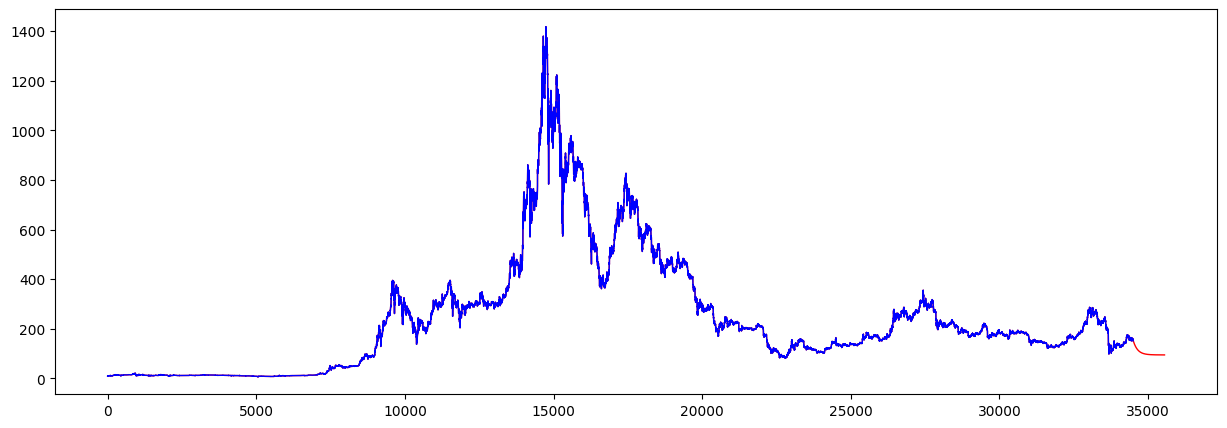

In [26]:
out = []
out = np.append(df.Close.values, new)
plt.figure(figsize=(15, 5))
plt.plot(out,linewidth=1, color="red")
plt.plot(df.Close.values,linewidth=1, color="blue")
plt.show()


In [27]:
len(out), len(df.Close)

(35553, 34497)